In [1]:
%load_ext autoreload
%autoreload 2
#from supervised.automl import AutoML
import importlib
import sqlite3
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn as sk
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, Normalizer, normalize, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV, RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
import sklearn.inspection
from sklearn.svm import NuSVC, SVC
from sklearn import metrics
import shap
import time
import xgboost
from highcharts import Highchart
import os
import sys
import gc
from joblib import Parallel, delayed
import joblib

# Importation de nos bibliothèques perso

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import src.data_tools as dt 
import src.eda as eda
import src.jsaguiar as jsr

# Recharger une bibliothèque sans redémarrer

In [4]:
importlib.reload(eda)

<module 'src.eda' from '/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/src/eda.py'>

# Utilisation du thème sombre avec Jupyter

In [5]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('onedork')

# PARTIE 2

Dans cette partie, nous reprendrons plus concisément tous ce qui a été vu plus haut, en tâchant d'être explicite et exhausitif.
Si nous le pouvons nous utiliserons la bibliothèque [feature-engine](https://github.com/solegalli/feature_engine) pour faire de nouvelles features. Notamment avec [cette méthode](https://feature-engine.readthedocs.io/en/latest/creation/MathematicalCombination.html) pour aller plus loin que notre création de feature avec les tables annexes à la table application_train.

In [6]:
app_train = pd.read_csv('../data/application_train.csv')

In [7]:
app_test = pd.read_csv('../data/application_test.csv')

In [8]:
bureau = pd.read_csv('../data/bureau.csv')

In [9]:
bureau_balance = pd.read_csv('../data/bureau_balance.csv')

In [10]:
credit_card = pd.read_csv('../data/credit_card_balance.csv')

In [11]:
installments_payments = pd.read_csv('../data/installments_payments.csv')

In [12]:
pos_cash_balance = pd.read_csv('../data/POS_CASH_balance.csv')

In [13]:
previous_app = pd.read_csv('../data/previous_application.csv')

In [14]:
# Contrôle des clés étrangères communes
np.intersect1d(app_train['SK_ID_CURR'],app_test['SK_ID_CURR'])

array([], dtype=int64)

In [15]:
# Contrôle des clés étrangères communes
np.intersect1d(app_train['SK_ID_CURR'],bureau['SK_ID_CURR']).shape

(263491,)

In [16]:
np.intersect1d(bureau_balance['SK_ID_BUREAU'],bureau['SK_ID_BUREAU']).shape

(774354,)

In [17]:
np.intersect1d(app_train['SK_ID_CURR'],pos_cash_balance['SK_ID_CURR']).shape

(289444,)

In [18]:
np.intersect1d(app_train['SK_ID_CURR'],credit_card['SK_ID_CURR']).shape

(86905,)

In [19]:
np.intersect1d(app_train['SK_ID_CURR'],previous_app['SK_ID_CURR']).shape

(291057,)

In [20]:
np.intersect1d(app_train['SK_ID_CURR'],installments_payments['SK_ID_CURR']).shape

(291643,)

In [21]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

## EDA

Pour réaliser notre eda nous prenons un objet

In [22]:
importlib.reload(eda)

<module 'src.eda' from '/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/src/eda.py'>

In [23]:
def plot_hist(X, col):
    #col = "EXT_SOURCE_3"
    BLUE = 'b'
    plt.figure(figsize=(5, 5))
    chart = sns.countplot(
    x=X[col],
    order=X[col].value_counts().iloc[:10].index,
    color=BLUE,
    )
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.title(f"{col} class distribution")
    plt.tight_layout(pad=2.0)
    plt.savefig(f'../img/EDA_00/histogram/hist_{col}.jpg')
    plt.show()
    plt.close()

In [24]:
def plot_categorial(X, col):
    plt.figure(figsize=(5, 5))
    a = X.loc[X['TARGET']==1][col]
    b = X.loc[X['TARGET']==0][col]
    list_a = []
    for index in X[col].unique():
        list_a.append(a.loc[a == index].count())
    list_b = []
    for index in X[col].unique():
        list_b.append(b.loc[b == index].count())
    plt.plot([], [], color ='blue', 
         label ='Mauvais Payeur')
    plt.plot([], [], color ='orange',
         label ='Bon Payeur')
    labels = [str(x) for x in list(X[col].unique())]
    if len(labels) < len(list_a):
        label.insert(-1, 'end')
    print(list_a, list_b)
    # Implementing stackplot on data
    #print(list_a, list_b, labels)
    plt.stackplot(labels,list_a, list_b,  
                   baseline ='zero', 
                  colors =['blue', 'orange'])
    plt.legend()
    plt.title(f"{col} segmentation")
    plt.xticks(labels,rotation=90);
    plt.xlabel('Interval de valeur')
    plt.ylabel('Nombre d\'observations')
    plt.tight_layout(pad=2.0)
    plt.savefig(f'../img/EDA_00/categorial/cat_{col}.jpg')
    plt.show()
    plt.close()
    

In [25]:
def ten_segments_stacked(X, col):
    X_bin = X.copy()
    X_bin['BINNED'] = pd.cut(X_bin[col].dropna(), 11)
    a = X_bin.loc[X_bin['TARGET']==1]['BINNED']
    b = X_bin.loc[X_bin['TARGET']==0]['BINNED']
    #print(X_bin['BINNED'].unique())
    list_a = []
    for index in X_bin['BINNED'].unique().sort_values():
        list_a.append(a.loc[a == index].count())
    list_b = []
    for index in X_bin['BINNED'].unique().sort_values():
        list_b.append(b.loc[b == index].count())
    plt.figure(figsize=(5, 5))
    plt.plot([], [], color ='blue', 
         label ='Mauvais Payeur')
    plt.plot([], [], color ='orange',
         label ='Bon Payeur')
    labels = [str(x) for x in list(X_bin['BINNED'].unique().sort_values())]
    if len(labels) < len(list_a):
        label.insert(-1, 'end')
    # Implementing stackplot on data
    #print(list_a, list_b, labels)
    plt.stackplot(labels,list_a, list_b,  
                   baseline ='zero', 
                  colors =['blue', 'orange'])
    plt.legend()
    plt.title(f"{col} segmentation")
    plt.xticks(labels,rotation=90);
    plt.xlabel('Interval de valeur')
    plt.ylabel('Nombre d\'observations')
    plt.tight_layout(pad=2.0)
    plt.savefig(f'../img/EDA_00/10_segment_stacked/stack_{col}.jpg')
    plt.show()
    plt.close()
    
    del X_bin
    gc.collect()

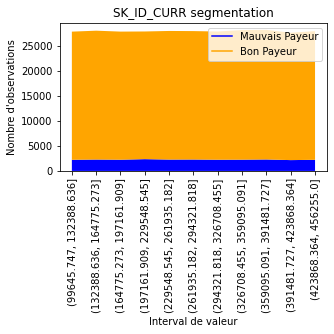

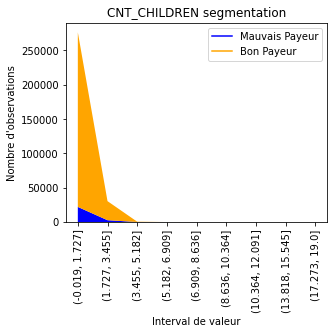

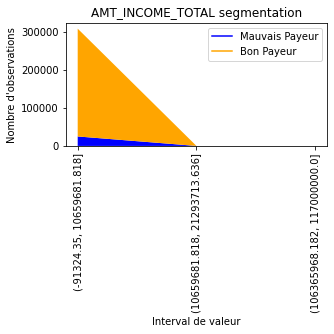

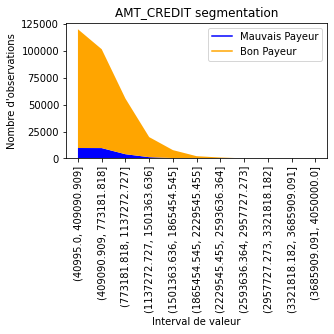

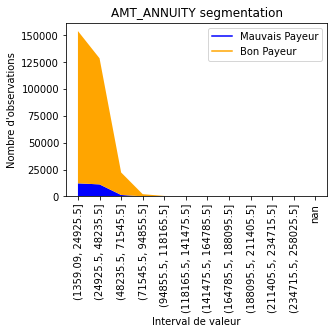

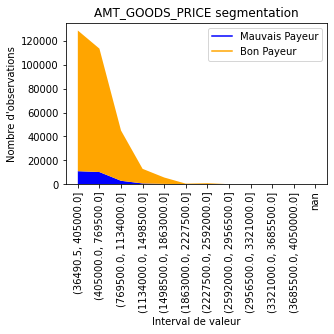

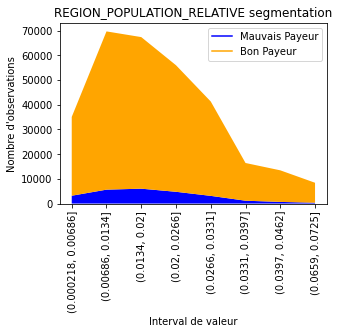

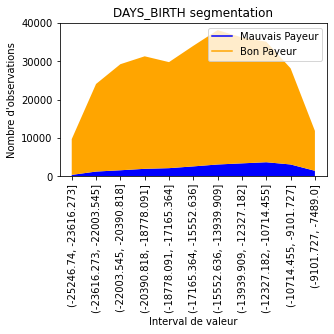

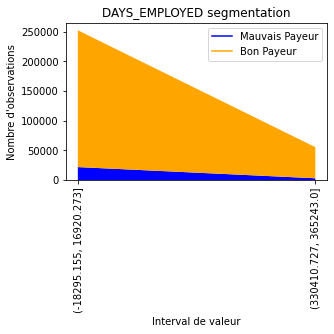

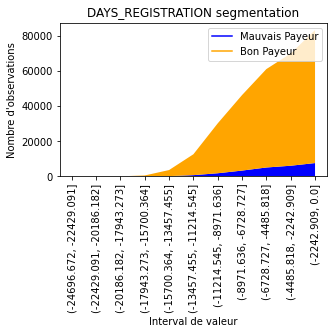

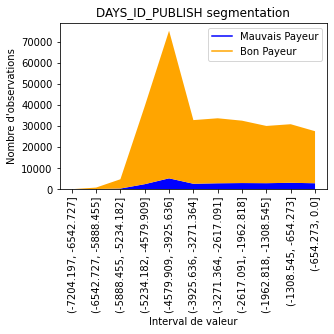

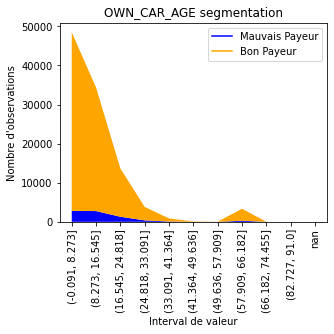

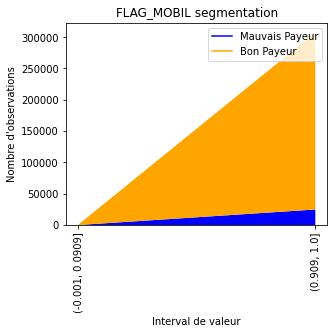

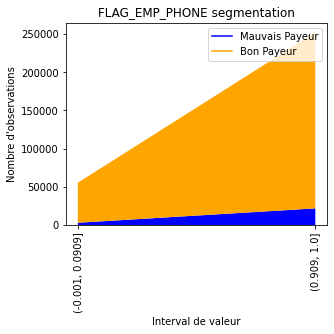

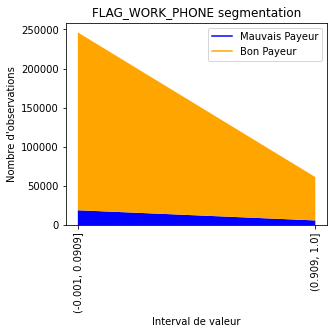

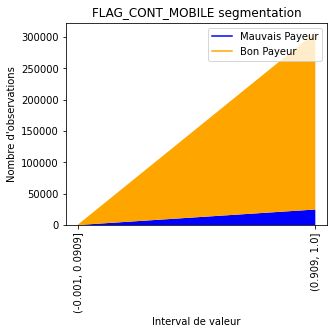

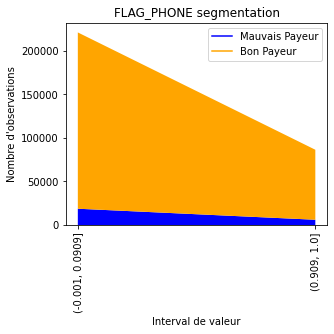

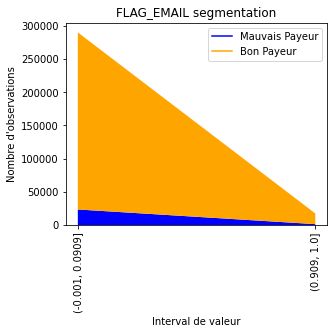

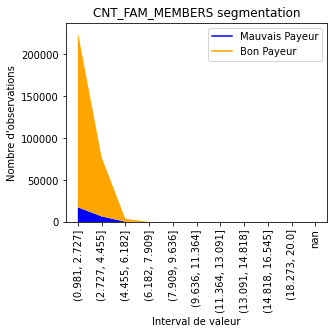

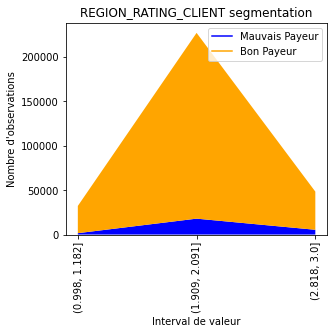

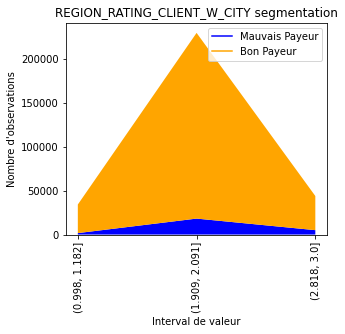

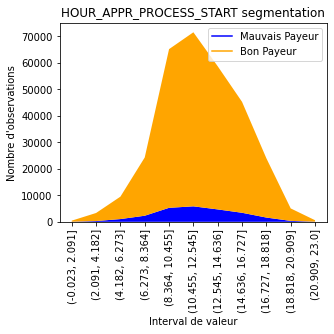

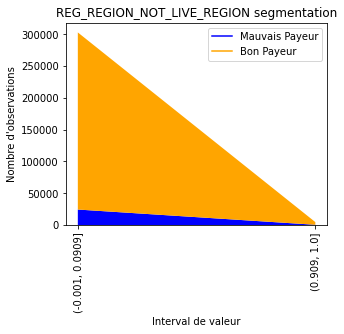

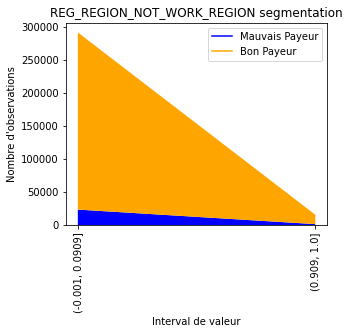

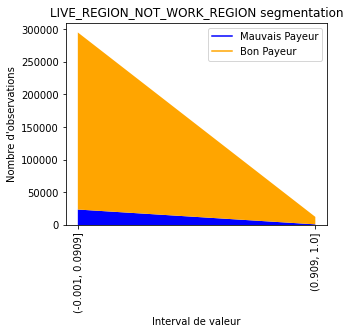

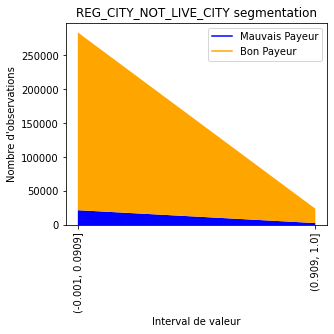

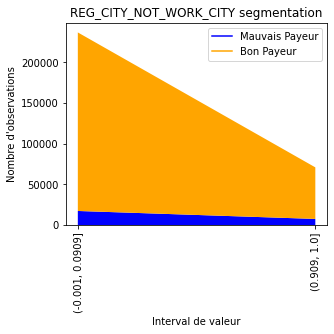

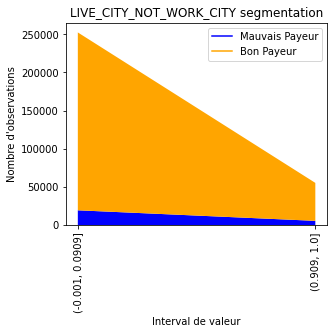

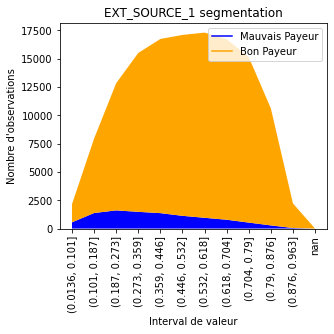

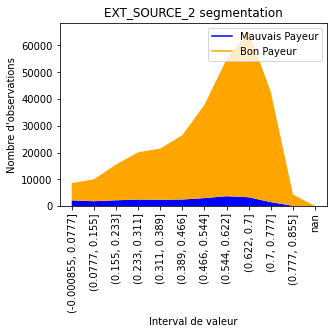

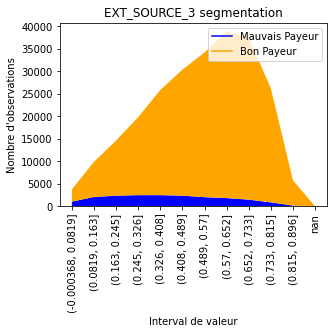

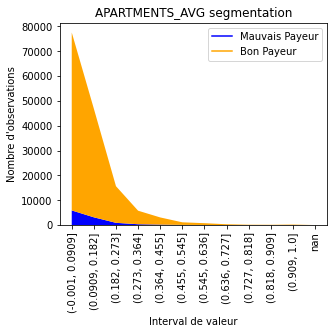

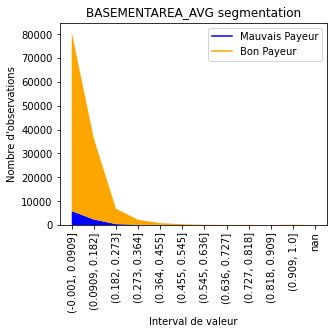

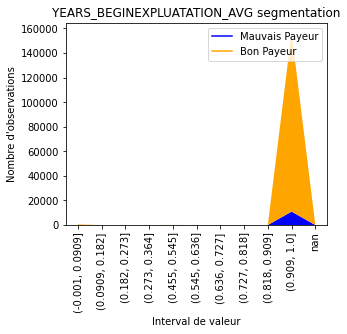

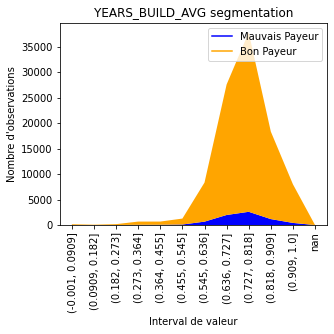

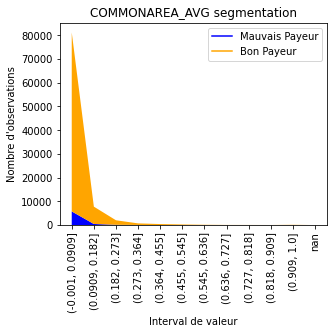

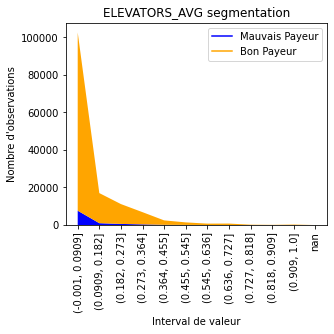

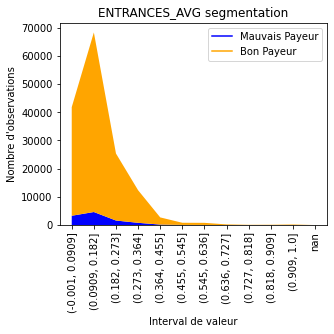

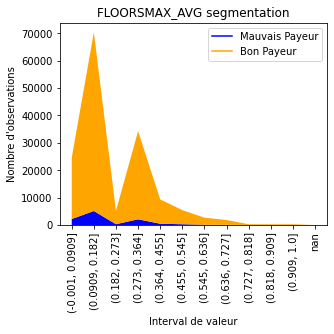

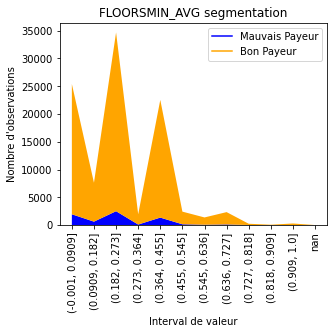

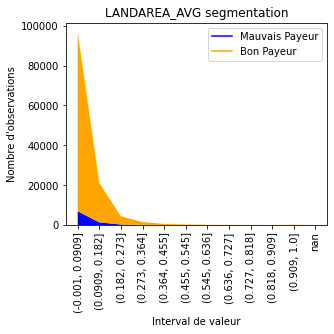

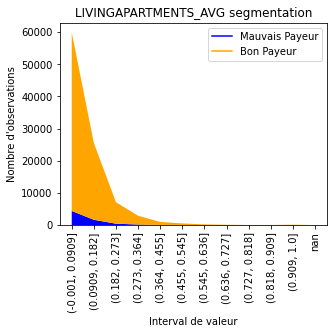

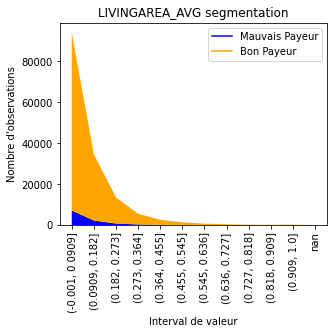

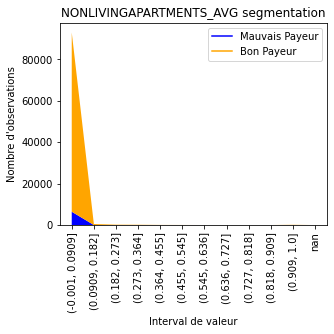

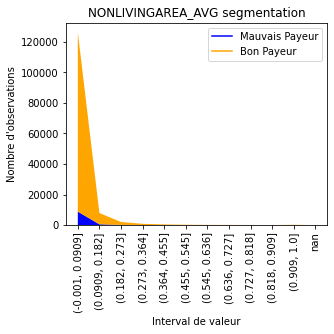

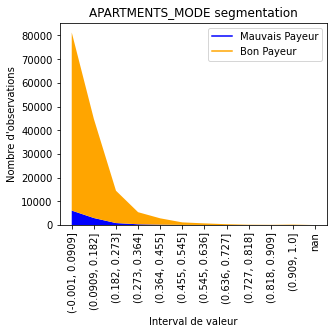

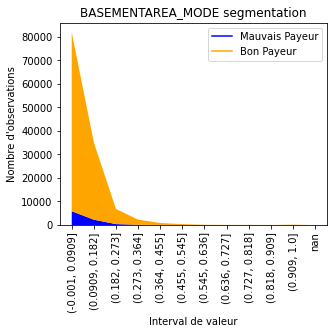

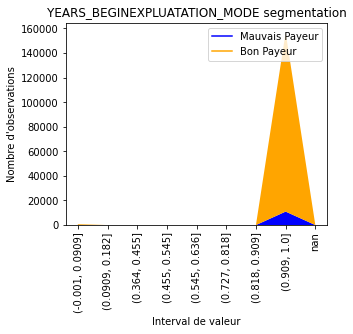

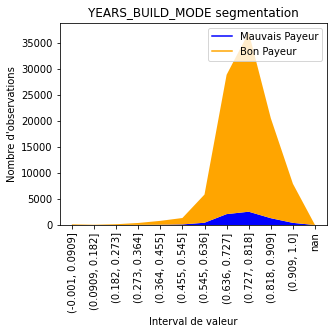

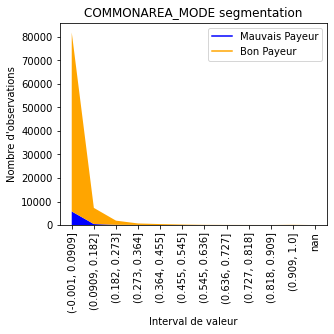

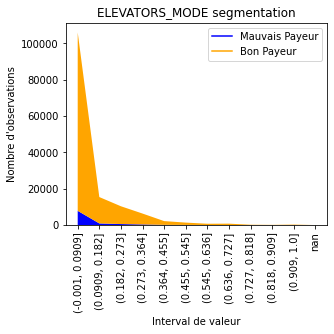

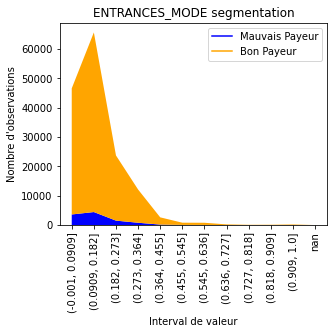

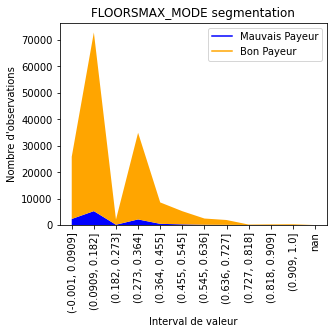

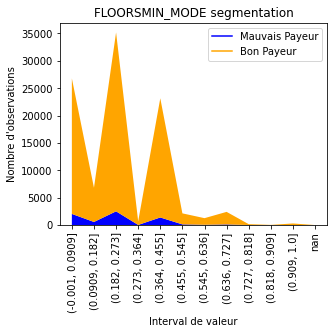

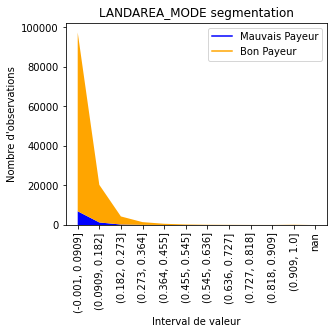

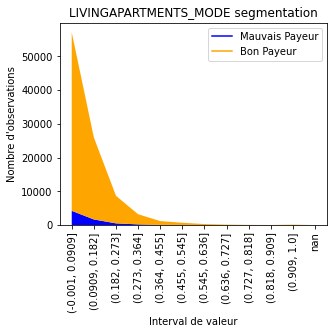

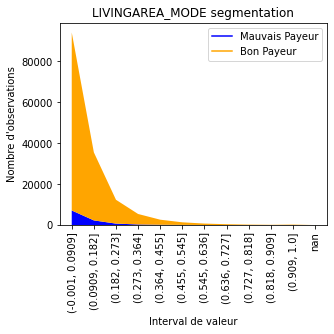

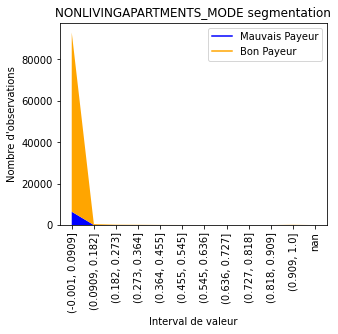

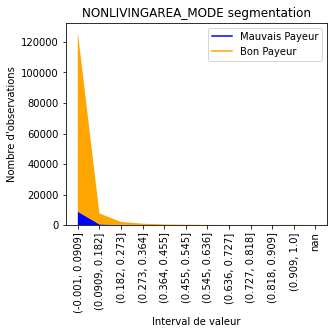

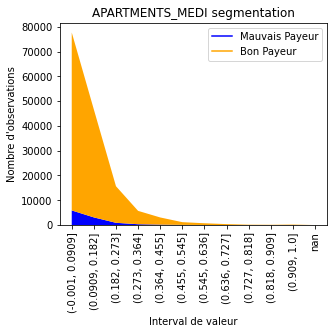

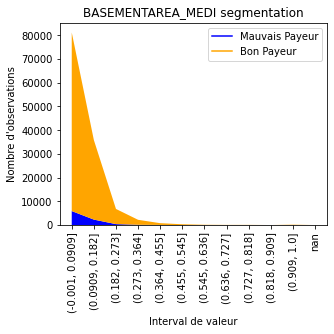

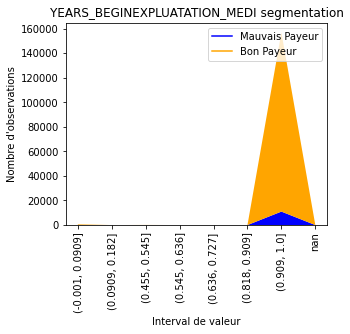

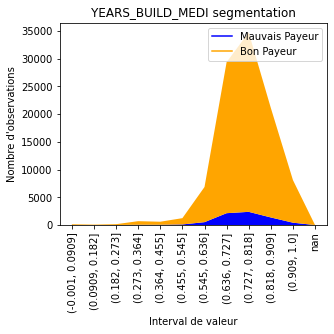

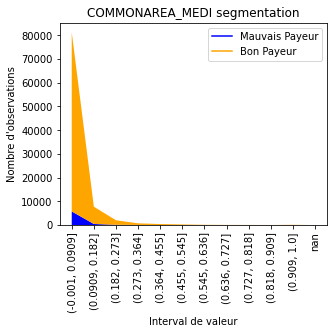

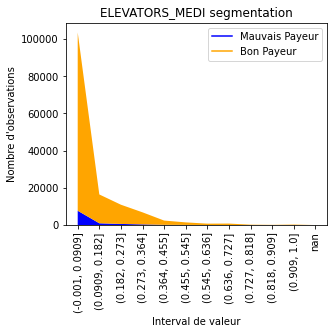

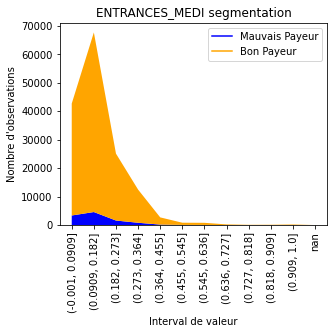

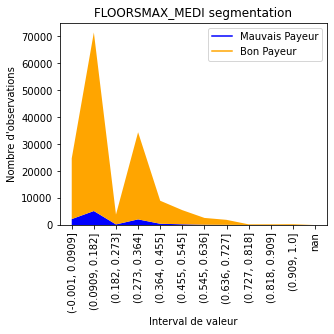

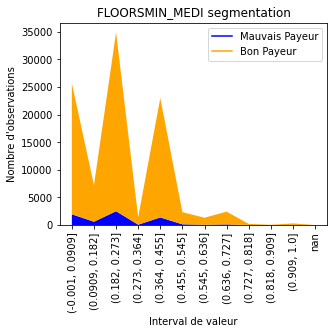

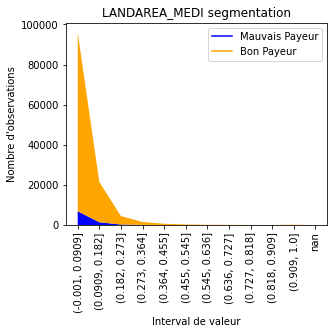

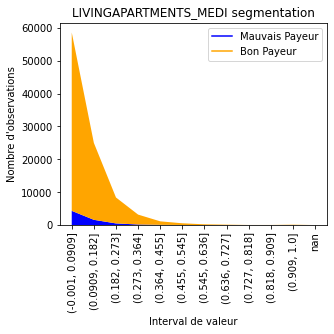

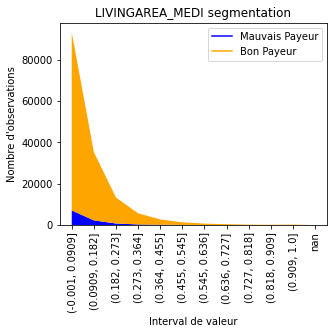

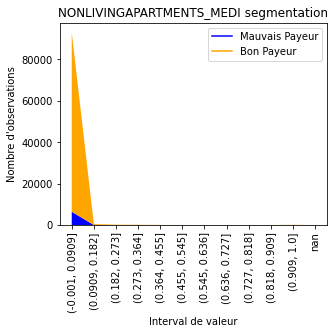

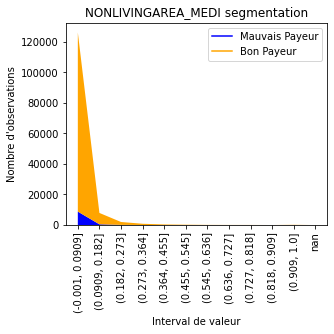

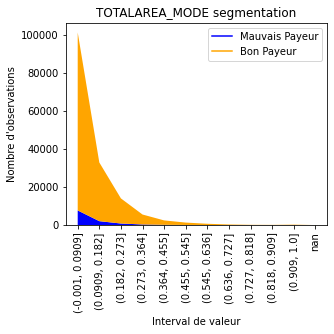

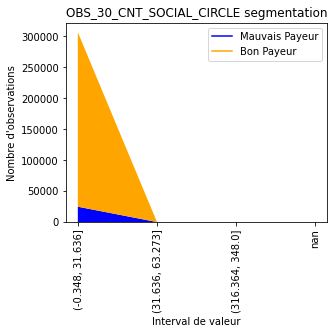

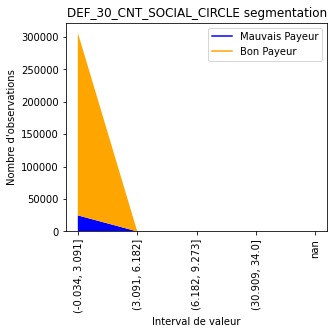

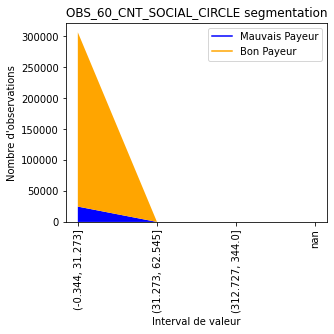

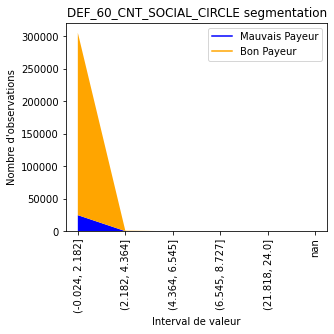

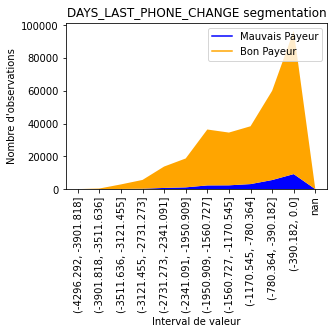

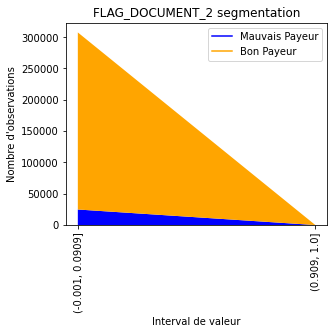

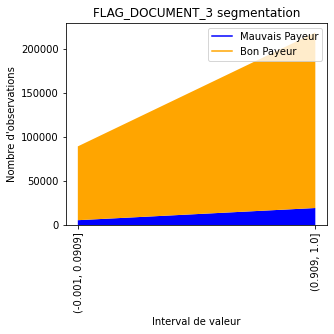

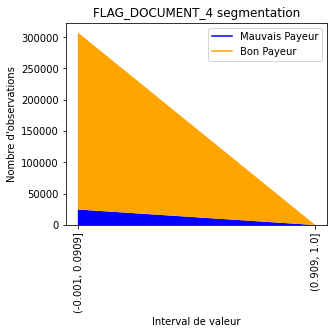

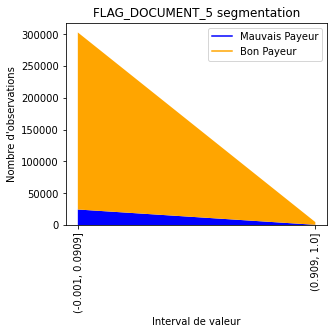

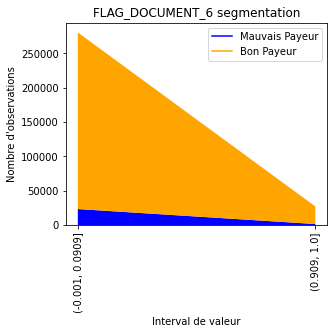

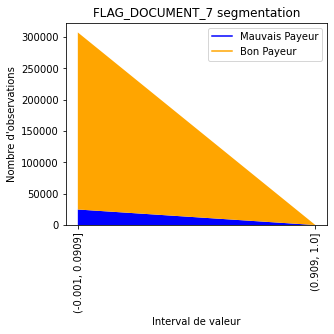

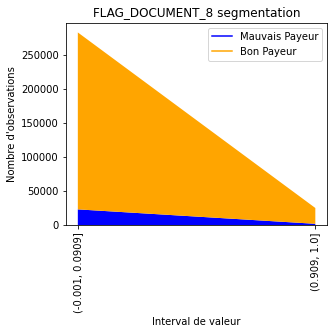

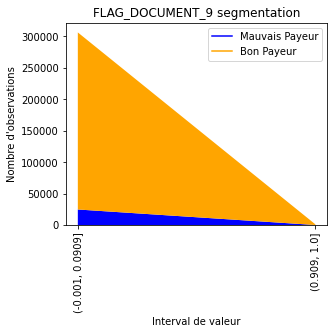

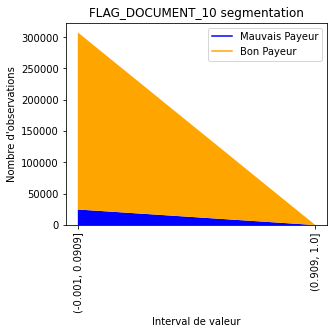

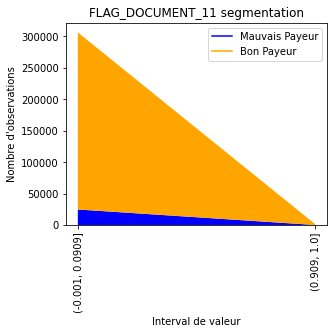

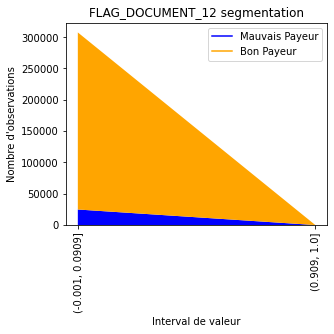

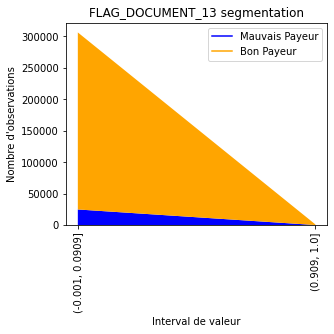

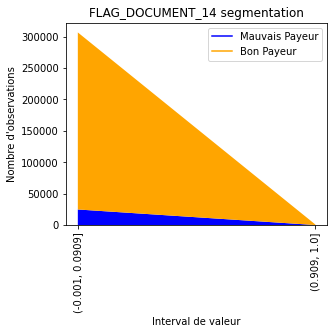

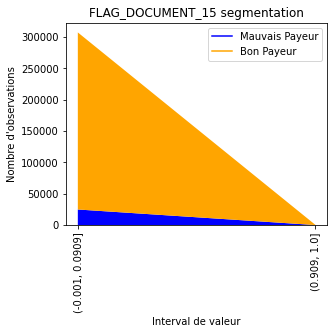

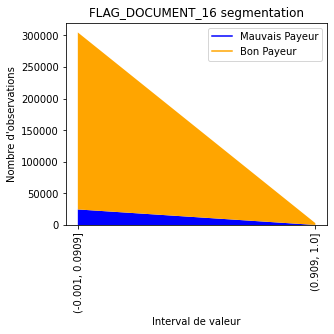

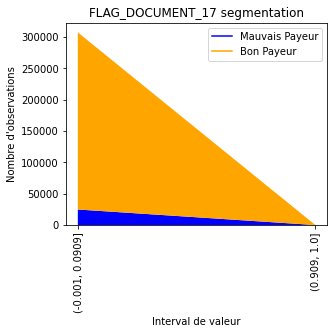

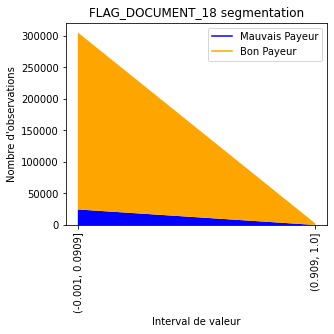

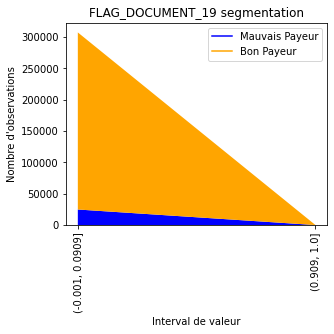

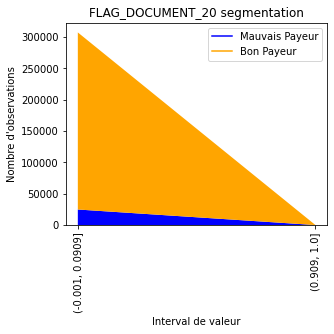

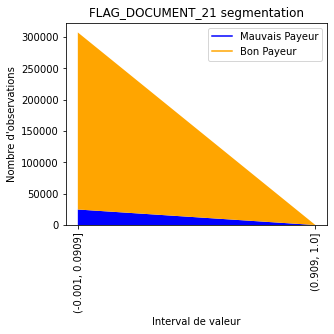

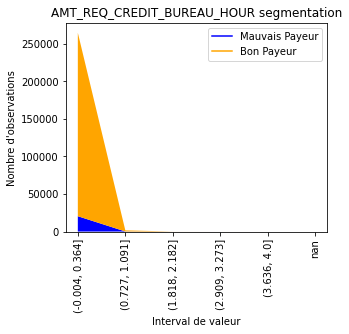

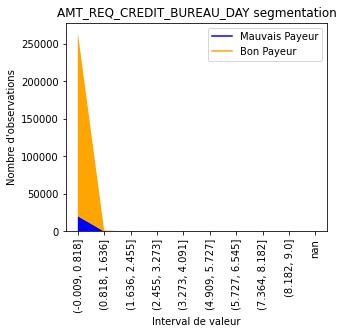

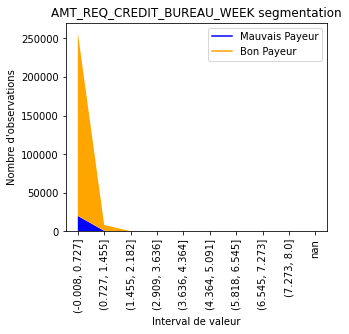

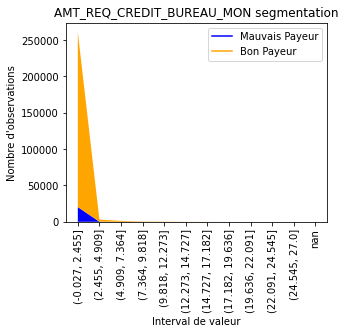

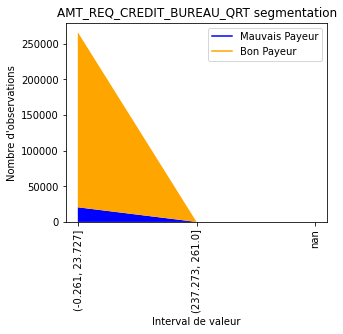

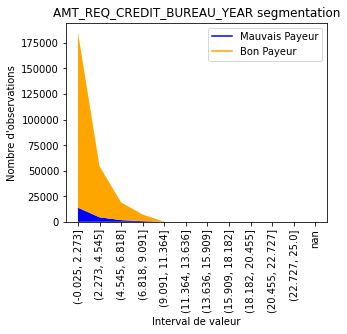

In [26]:
with Parallel(n_jobs=8) as parallel:
    for col in app_train.columns:
        if col not in 'TARGET':
            col_type = str(app_train[col].dtype)
            if col_type.startswith("float") or col_type.startswith("int") or col_type.startswith("uint"):
                ten_segments_stacked(app_train, col)

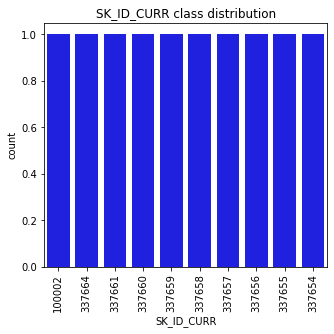

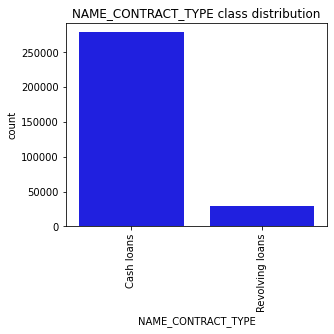

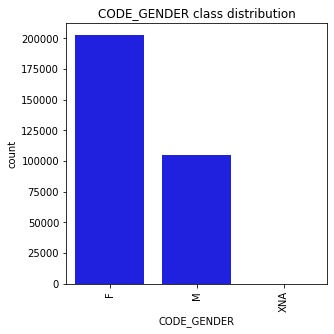

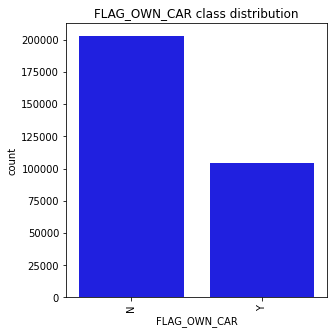

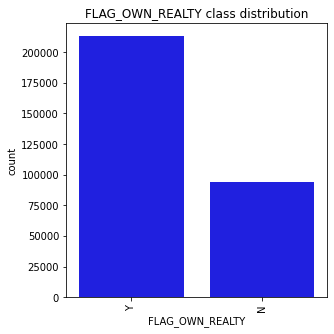

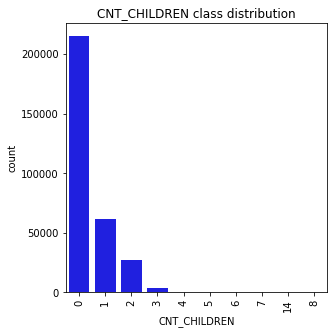

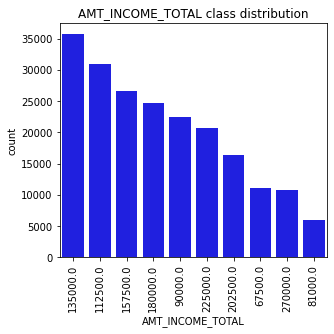

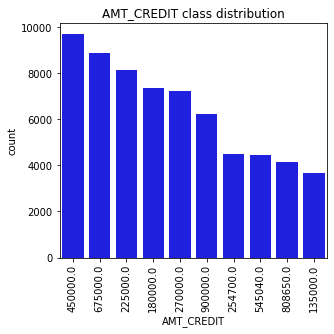

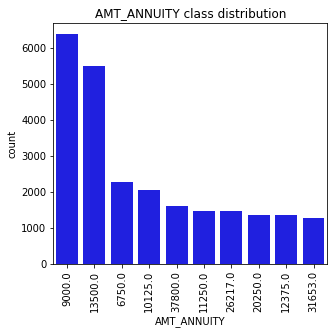

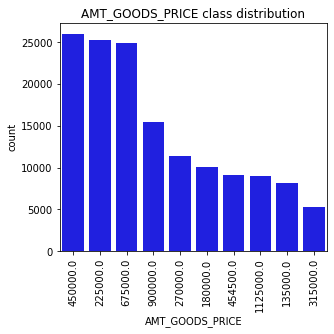

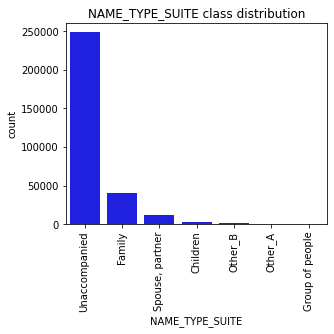

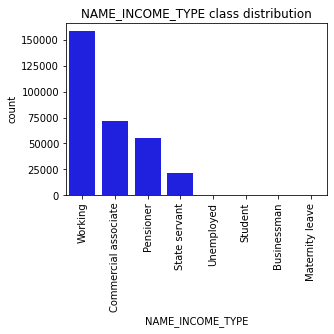

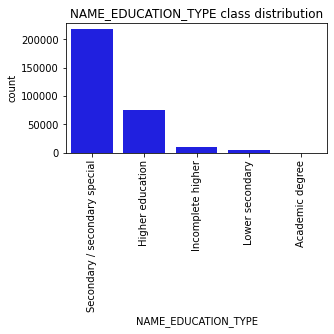

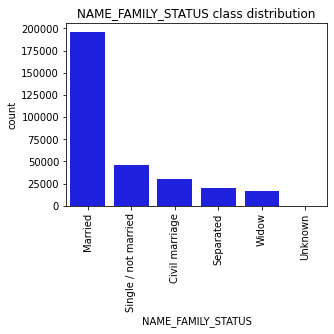

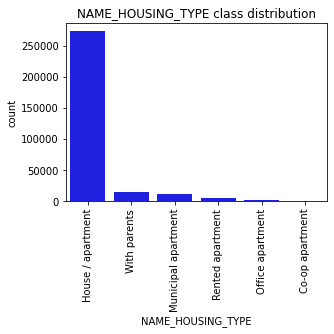

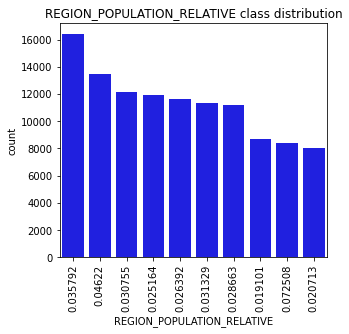

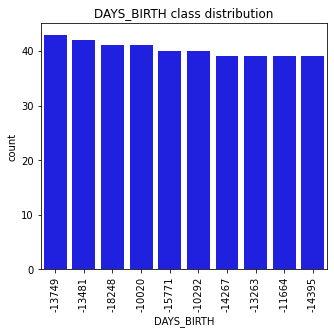

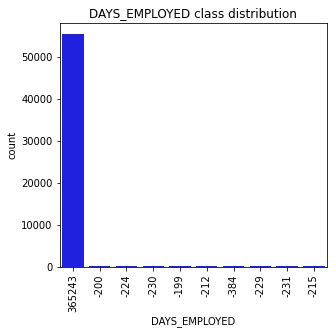

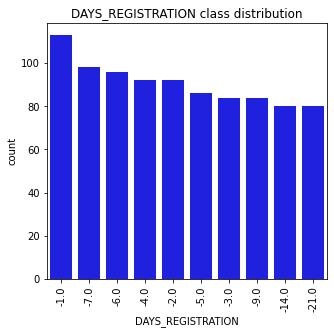

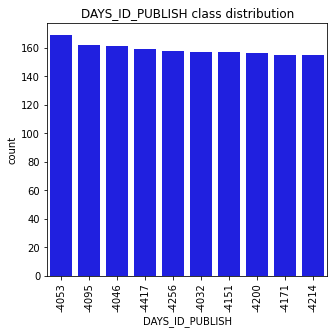

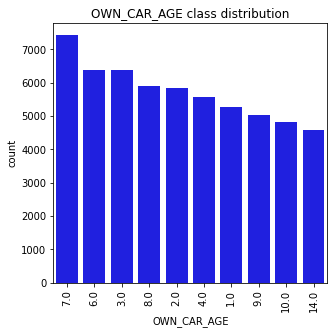

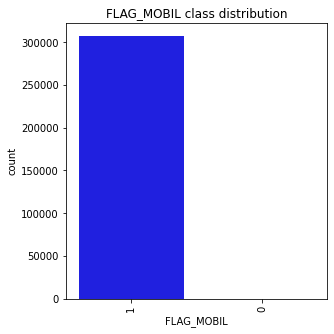

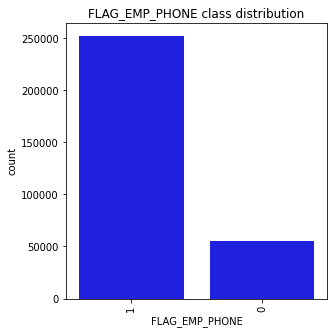

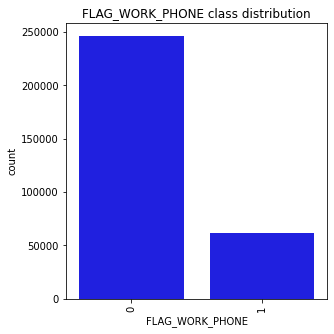

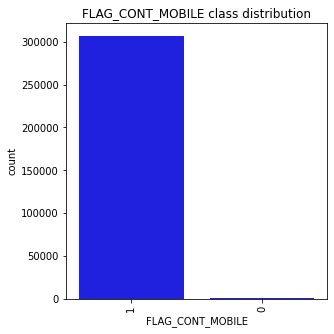

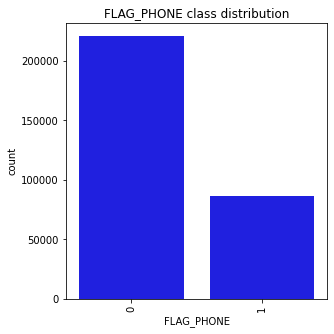

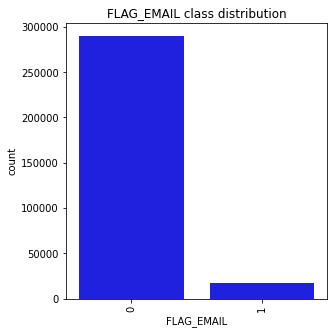

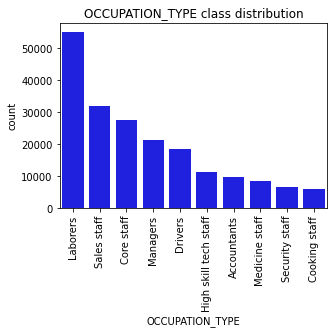

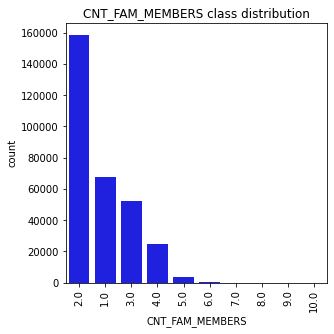

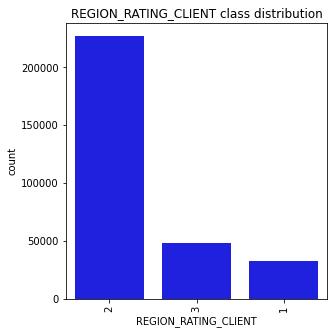

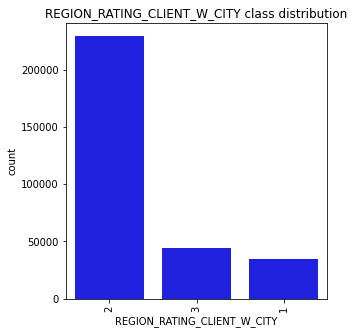

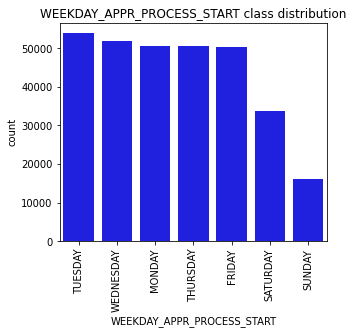

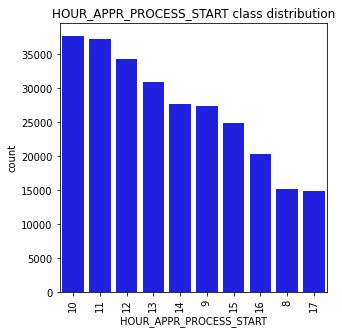

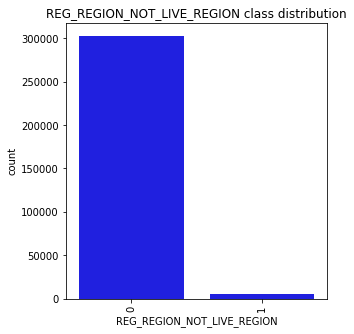

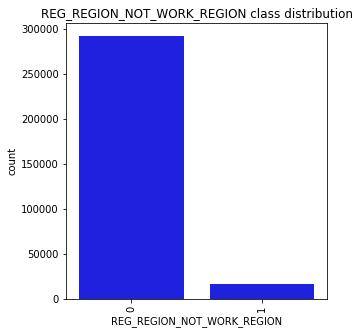

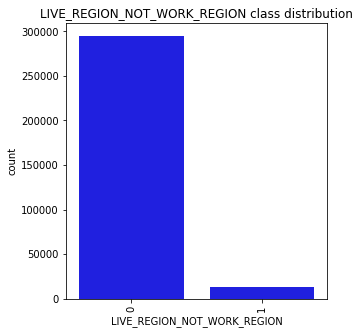

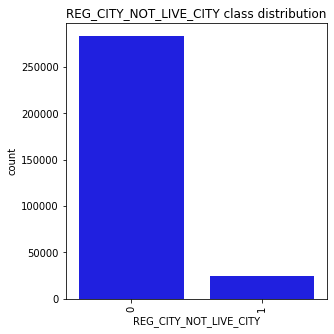

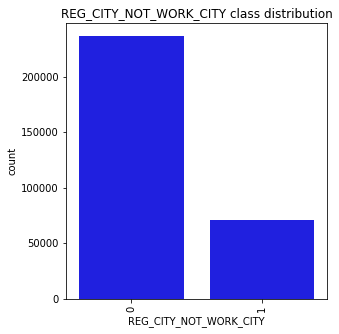

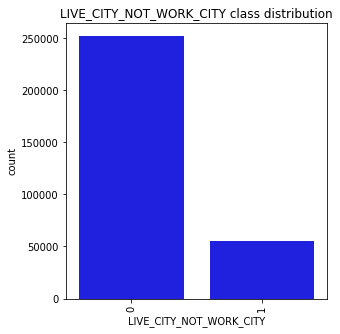

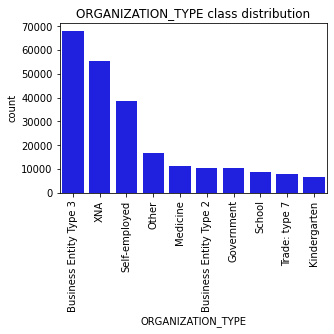

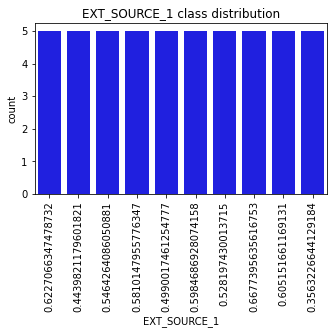

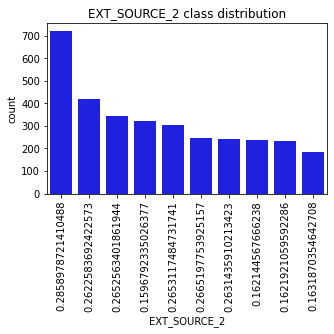

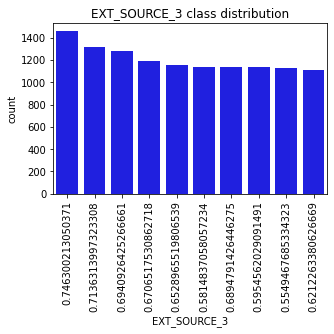

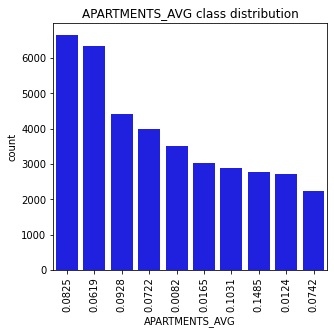

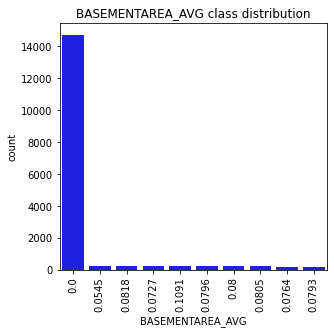

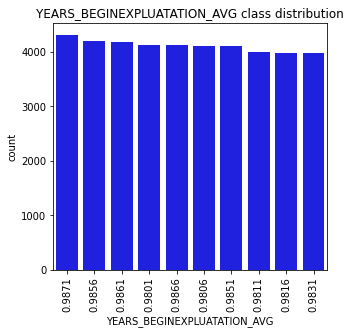

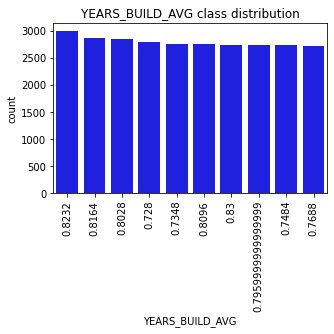

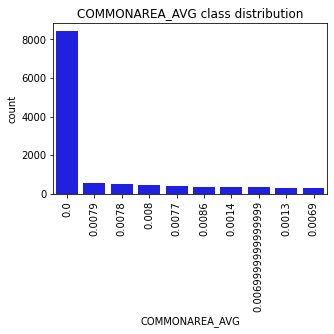

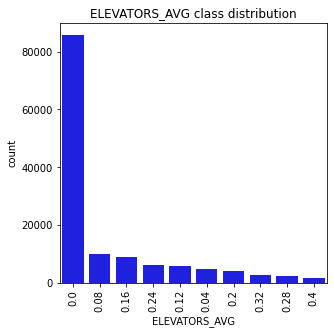

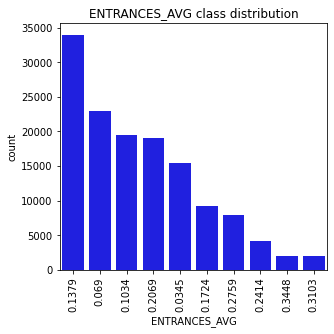

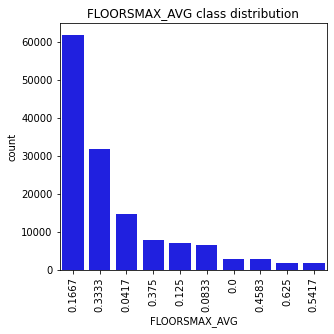

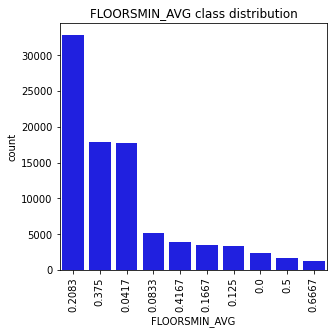

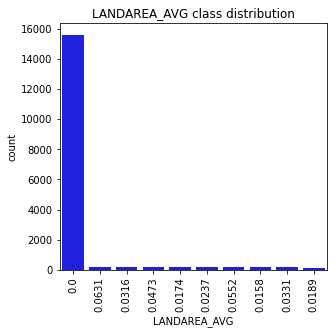

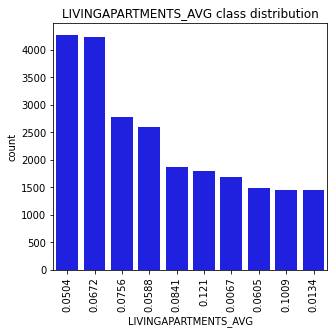

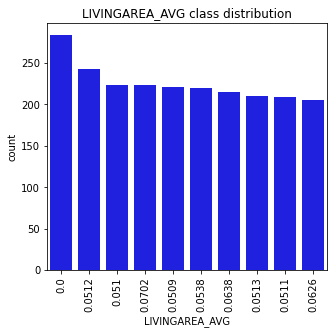

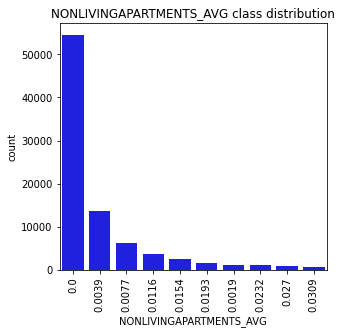

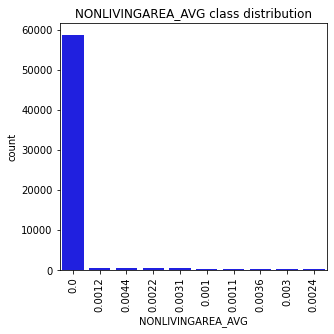

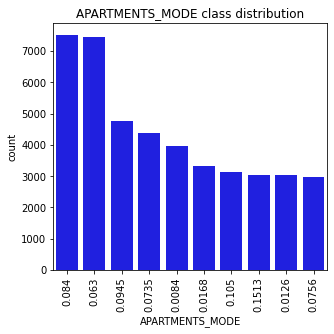

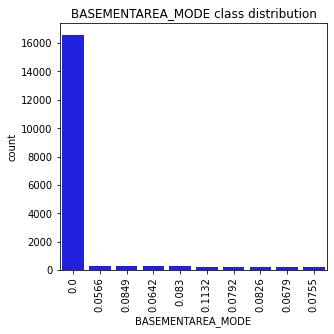

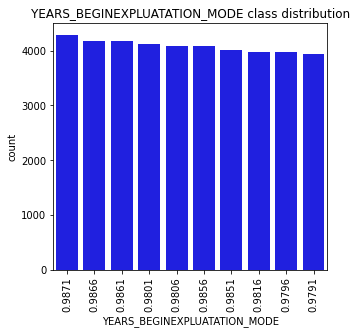

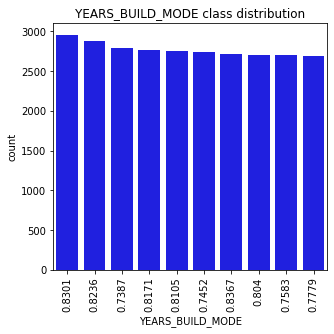

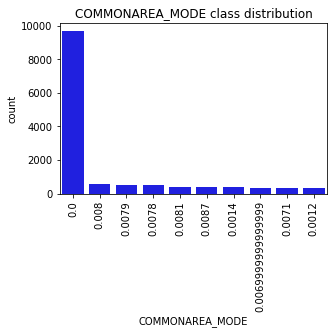

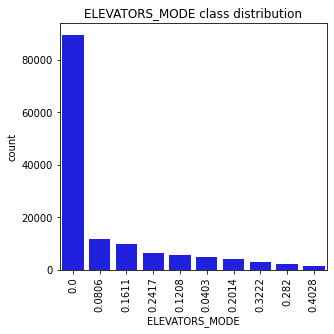

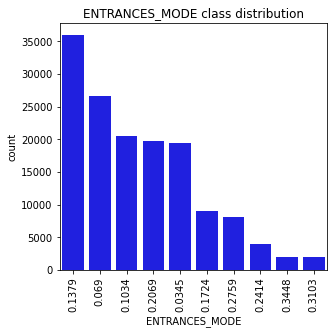

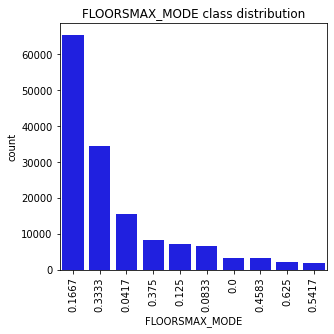

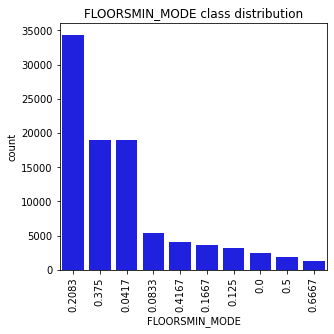

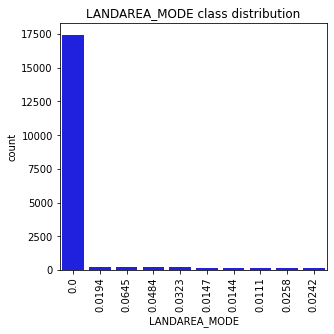

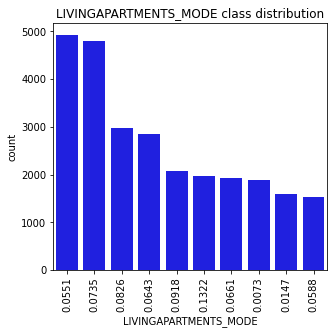

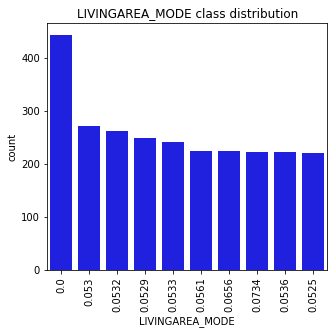

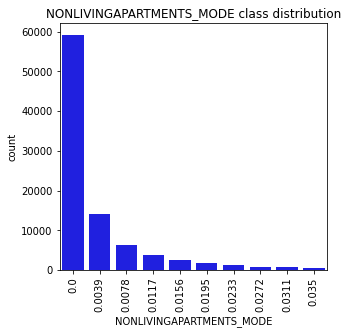

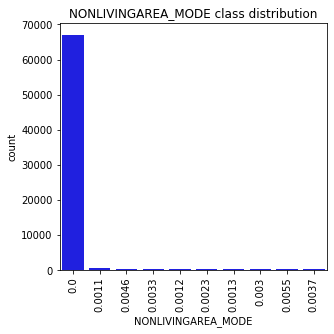

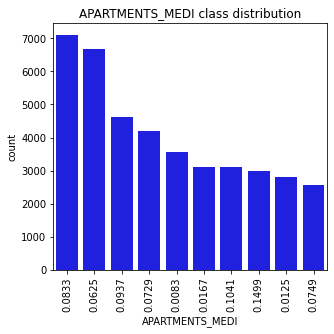

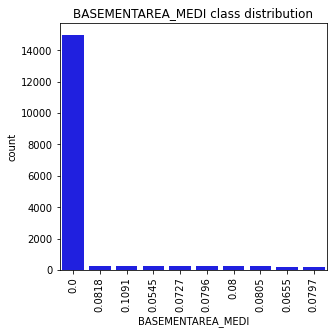

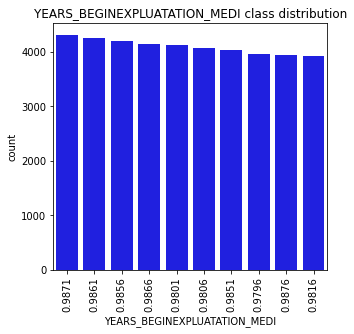

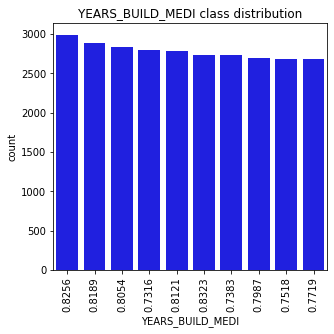

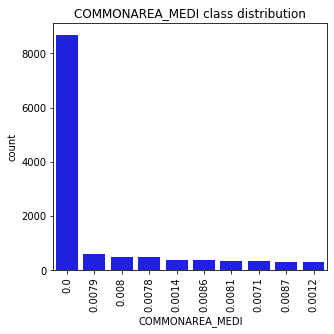

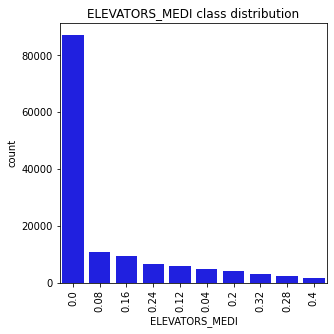

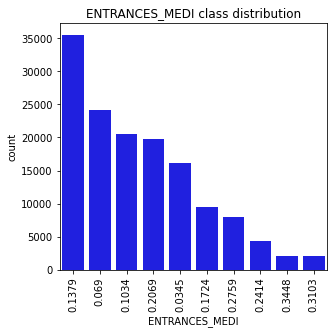

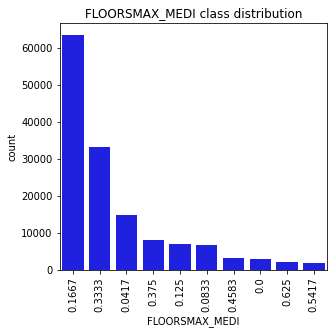

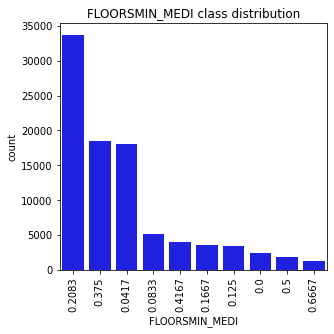

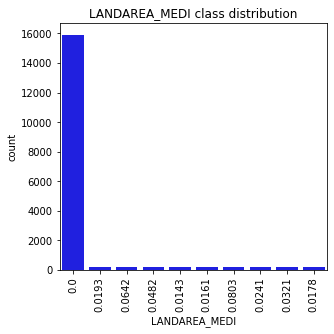

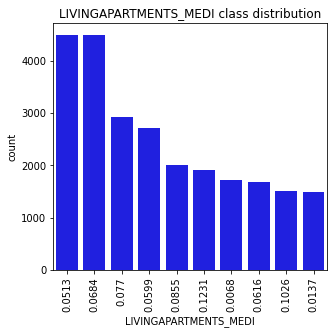

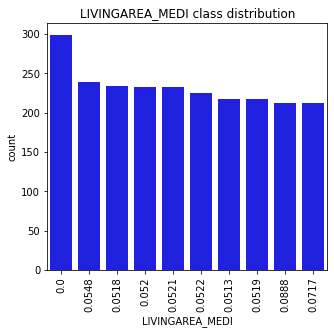

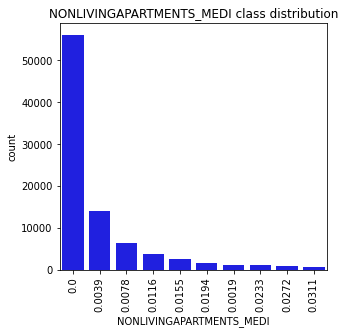

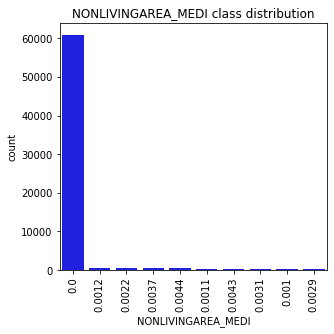

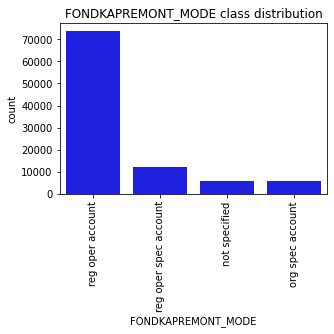

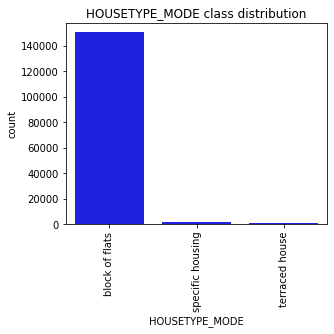

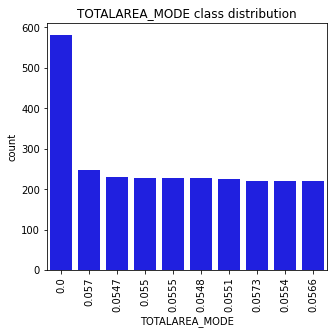

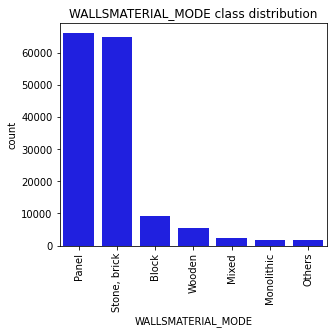

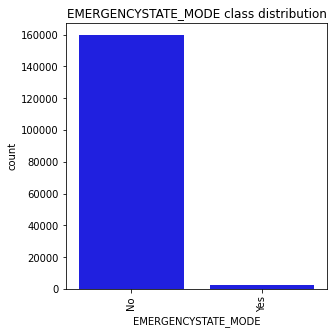

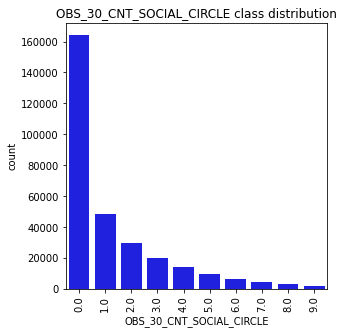

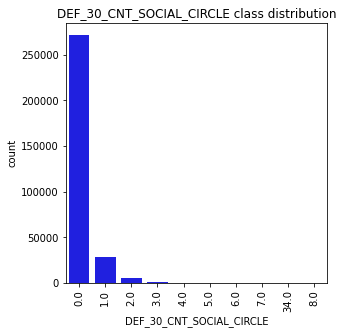

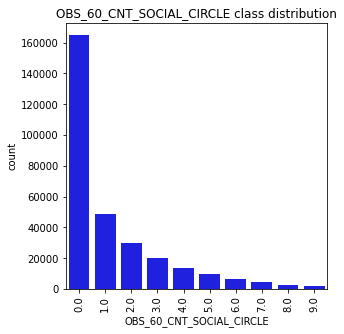

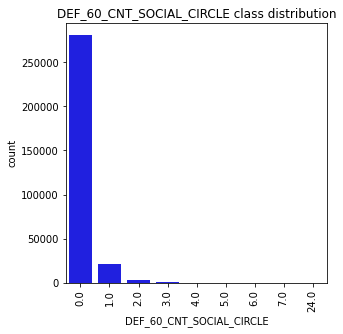

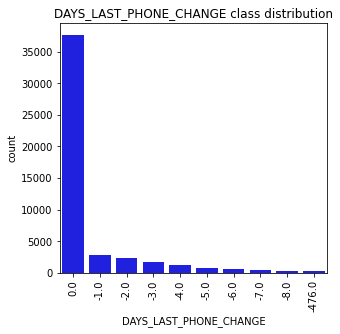

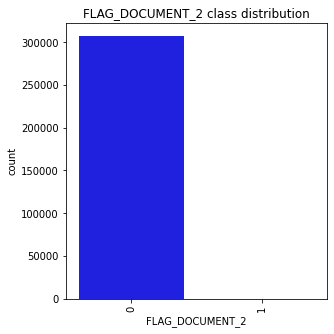

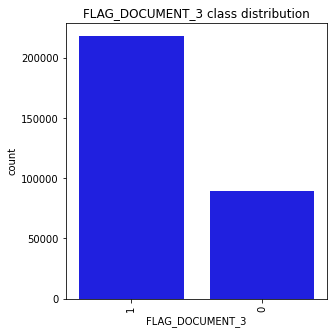

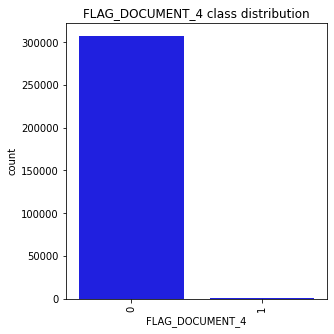

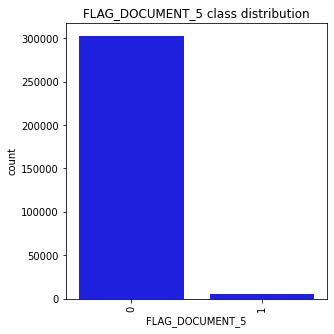

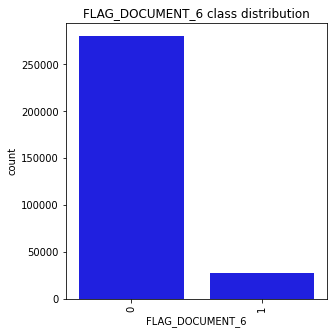

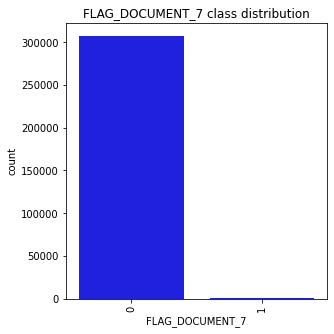

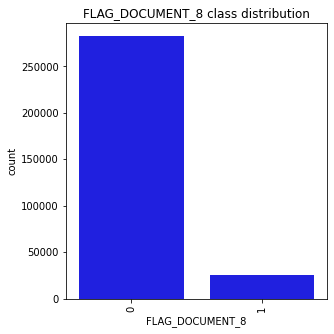

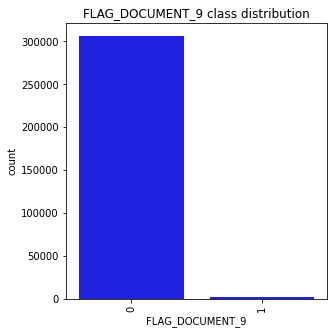

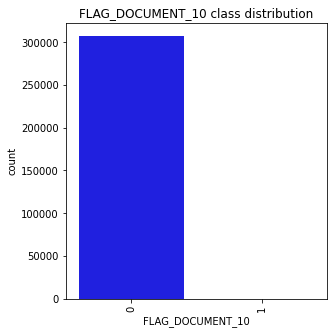

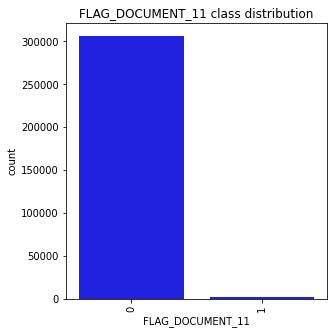

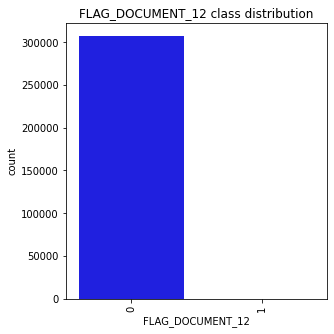

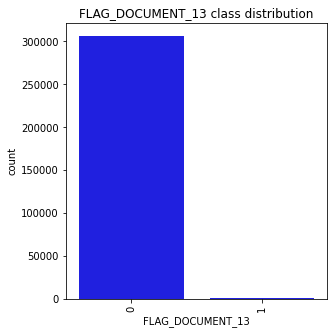

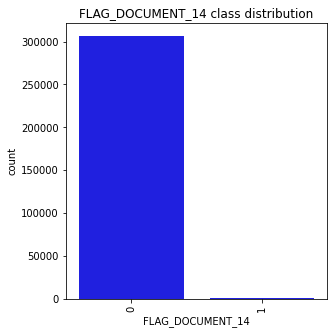

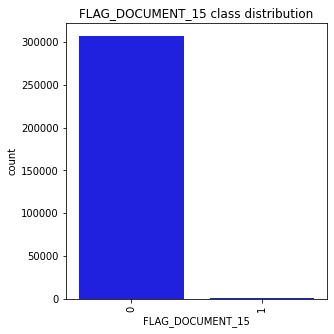

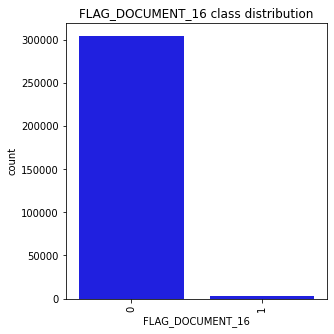

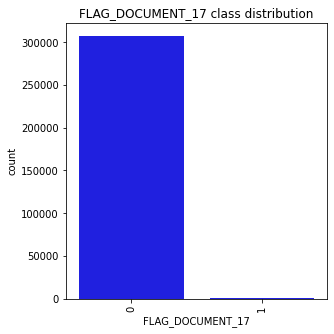

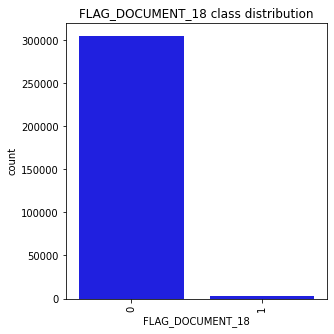

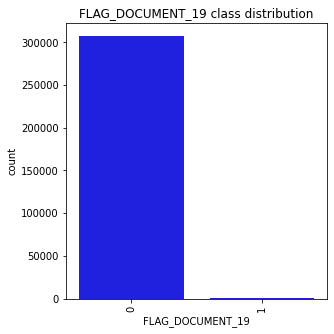

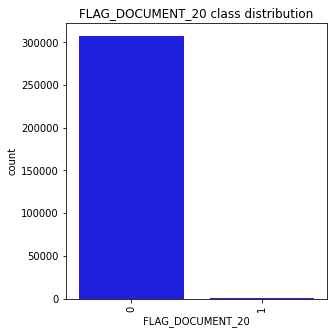

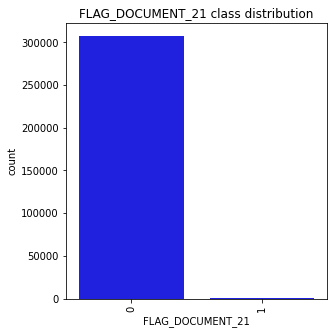

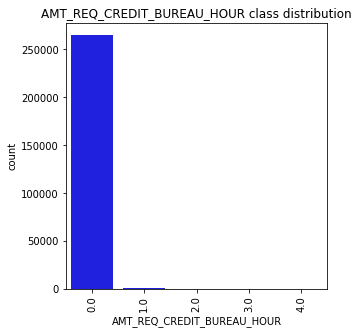

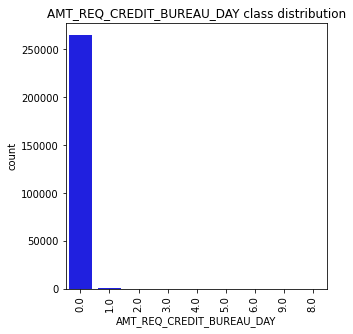

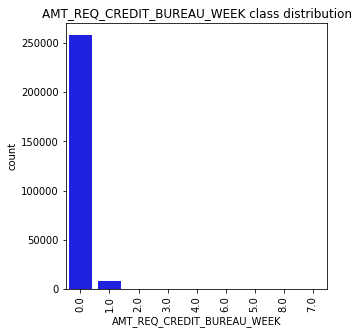

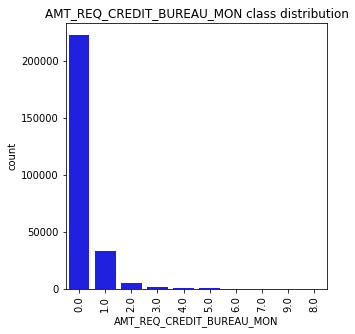

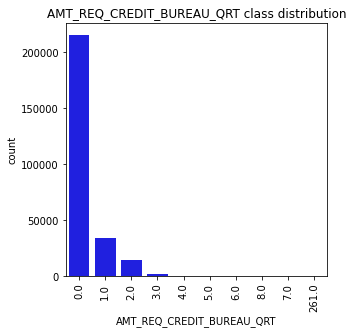

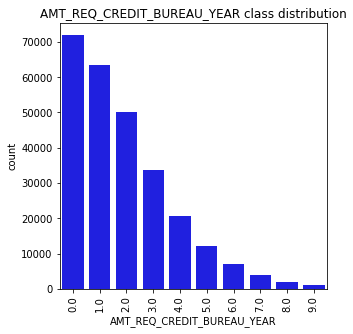

In [27]:
with Parallel(n_jobs=8) as parallel:
    for col in app_train.columns:
        if col not in 'TARGET':
            col_type = str(app_train[col].dtype)
            plot_hist(app_train, col)

[23221, 1604] [255011, 27675]


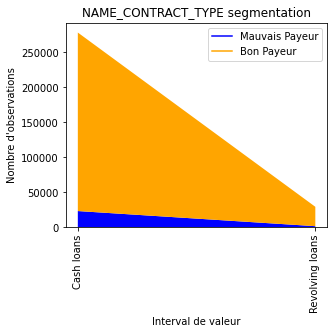

[10655, 14170, 0] [94404, 188278, 4]


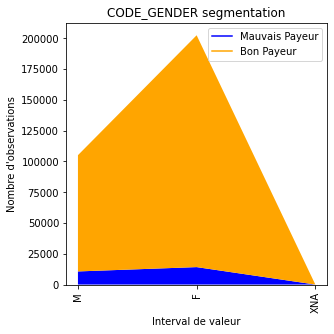

[17249, 7576] [185675, 97011]


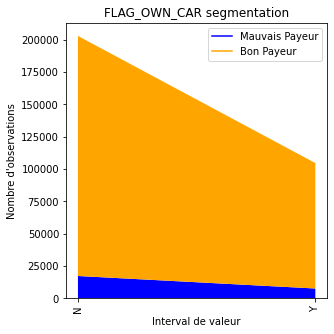

[16983, 7842] [196329, 86357]


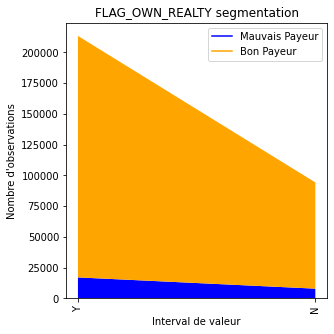

[20337, 3009, 895, 241, 76, 0, 174, 23] [228189, 37140, 10475, 3026, 790, 0, 1596, 248]


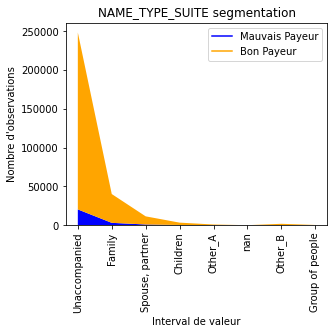

[15224, 1249, 5360, 2982, 8, 0, 0, 2] [143550, 20454, 66257, 52380, 14, 18, 10, 3]


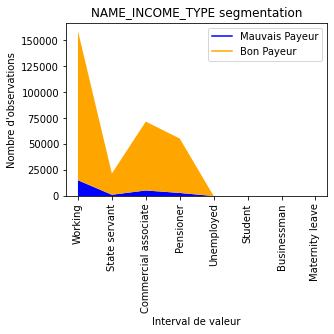

[19524, 4009, 872, 417, 3] [198867, 70854, 9405, 3399, 161]


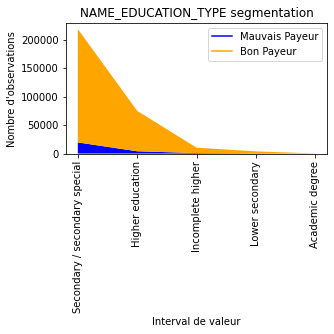

[4457, 14850, 2961, 937, 1620, 0] [40987, 181582, 26814, 15151, 18150, 2]


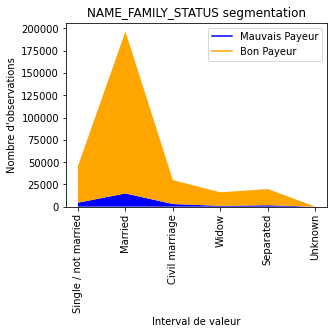

[21272, 601, 1736, 955, 172, 89] [251596, 4280, 13104, 10228, 2445, 1033]


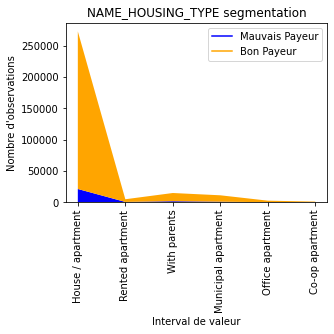

[5838, 1738, 474, 1328, 0, 2107, 3092, 447, 621, 175, 572, 722, 701, 152, 359, 59, 92, 34, 36] [49348, 25832, 9339, 20043, 0, 16496, 29010, 4206, 5325, 2477, 7965, 5999, 10679, 1196, 1734, 692, 1213, 492, 527]


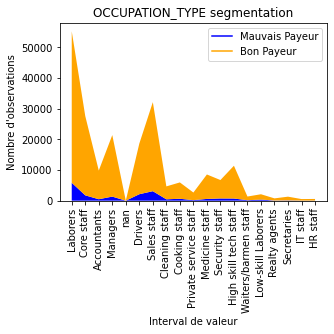

[4238, 3934, 4098, 1283, 2670, 4101, 4501] [47696, 46780, 46493, 14898, 31182, 46237, 49400]


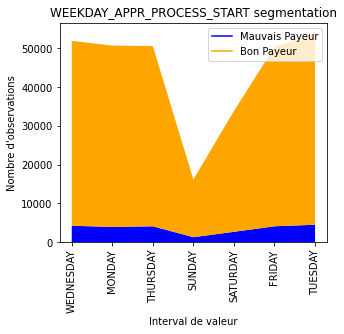

[6323, 526, 726, 5, 1275, 2990, 63, 737, 900, 3908, 172, 785, 235, 484, 740, 234, 135, 104, 96, 501, 115, 40, 324, 133, 65, 187, 117, 487, 182, 89, 257, 212, 21, 62, 105, 361, 348, 130, 225, 34, 29, 33, 9, 14, 29, 31, 41, 7, 24, 35, 3, 29, 9, 2, 44, 3, 42, 8] [61669, 8367, 9678, 80, 15408, 52384, 887, 10456, 9653, 34504, 2032, 5936, 2723, 6396, 7091, 2470, 2499, 1471, 1878, 4897, 924, 520, 2923, 1767, 1262, 1000, 2224, 5497, 1975, 788, 2197, 1599, 358, 904, 1202, 3131, 2930, 2377, 3143, 563, 602, 425, 192, 355, 288, 317, 558, 102, 281, 394, 46, 231, 58, 62, 533, 21, 354, 104]


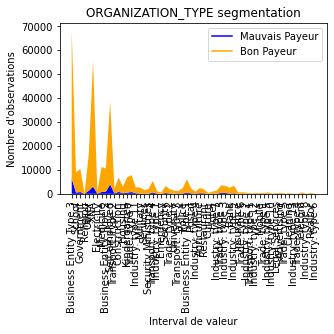

[5152, 0, 327, 792, 429] [68678, 0, 5292, 11288, 5258]


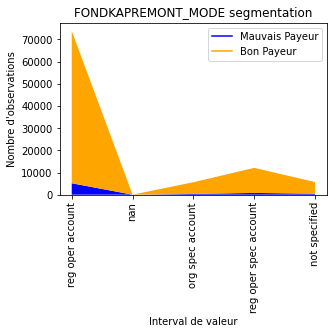

[10450, 0, 103, 152] [140053, 0, 1109, 1347]


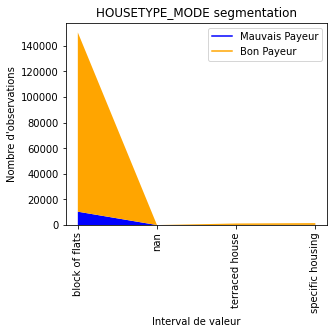

[4800, 650, 0, 4192, 173, 520, 135, 84] [60015, 8603, 0, 61848, 2123, 4842, 1490, 1695]


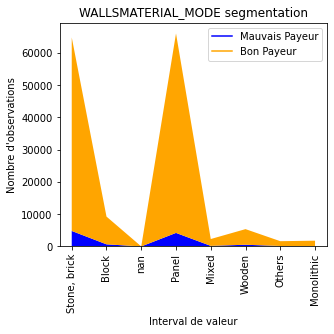

[11104, 0, 223] [148324, 0, 2105]


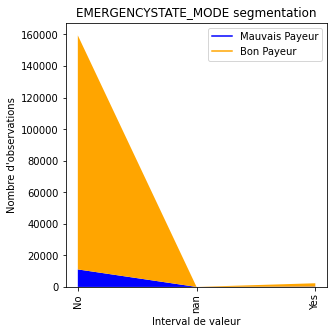

In [28]:
with Parallel(n_jobs=8) as parallel:
    for col in app_train.columns:
        if col not in 'TARGET':
            col_type = str(app_train[col].dtype)
            if col_type.startswith("object"):
                plot_categorial(app_train, col)

In [29]:
!python app_v1.py

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app 'app_v1' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
^C


## EDA Information

### Utilisation de la parallélisation des calculs

In [35]:
def choose_num_col(X):
    col_list = []
    for col in app_train.columns:
        if col not in 'TARGET':
            col_type = str(app_train[col].dtype)
            if col_type.startswith("float") or col_type.startswith("int") or col_type.startswith("uint"):
                col_list.append(col)
    return col_list
col_list = choose_num_col(app_train)

In [36]:
import time
importlib.reload(eda)
start = time.time()
df = eda.table(app_train[col_list])
end = time.time()
print('avec 1 cœurs', end - start)


dtypes: float64(65), int64(40), 

memory usage: 246.4 MB


Nombre de lignes: 307511


Nombre de valeurs non-nulles: 23900561


Nombre de valeurs nulles: 8388094

avec 1 cœurs 13.288738489151001


In [37]:
def eda_table_speed(X, col_list):
    import time
    app_train = X
    importlib.reload(eda)
    df = pd.DataFrame()
    start = time.time()
    with Parallel(n_jobs=8) as parallel:
        result = parallel(delayed(eda.table)(app_train[x]) for x in col_list)
        df = df.append(result)
    df = df.reset_index().drop('index', axis=1)
    end = time.time()
    print('avec 8 cœurs', end - start)


Nous avons calculer en 4 fois moins de temps grâce à la parallélisation. Cela nous permettra plus tard de travailler avec plus de colonnes dans notre EDA sur notre machine 8 cœurs.

In [38]:
eda.column_plot(df, 'mean', 'Nombre de valeurs null', 'en %', 'Total des valeurs')

In [39]:
eda.column_plot(df, 'unique', 'Nombre de valeurs unique', 'en quantitatif', 'Total des valeurs')

In [40]:
eda.column_plot(df, 'pct_null', 'Nombre de valeurs null', 'en %', 'Total des valeurs')

In [41]:
eda.column_plot(df, 'outliers', 'Nombre de valeurs aberrante', 'en %', 'Total des valeurs')

In [42]:
eda.column_plot(df, 'max', 'Maximum', 'en %', 'Total des valeurs')

In [43]:
eda.column_plot(df, 'min', 'Minimum', 'en %', 'Total des valeurs')

In [44]:
eda.boxplot(app_train, 'DAYS', 'entiers')

Nous observons que les valeurs ne sont pas traiter comme des nombres négatifs, ce qui est une faute
beaucoup de nombre sont positif et ne représente pas le sens présenté dans cette colonne, donc nous allons remplacer toutes ces valeurs par des valeurs nulles, quitte à changer automatique le type en flottant pour accepter les np.nan. 

In [45]:
X_num, y = app_train[col_list].copy(), app_train['TARGET']
X_num['DAYS_EMPLOYED'] = X_num['DAYS_EMPLOYED'].apply(lambda x: np.nan if x > 0 else x)

In [46]:
eda.boxplot(X_num.join(y), 'DAYS', 'flottants')

In [47]:
## Remplacement des valeurs nulles
imp_mean_si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean_si.fit(X_num)

SimpleImputer(strategy='most_frequent')

In [48]:
start = time.time()
imp_mean = IterativeImputer(random_state=0, 
                            tol=1e-6, 
                            verbose=2, 
                            imputation_order='random',
                            max_iter=3,
                            initial_strategy='most_frequent',
                            n_nearest_features=7)
imp_mean.fit(X_num)
end = time.time()
print('avec 1 cœurs', end - start)

[IterativeImputer] Completing matrix with shape (307511, 105)
[IterativeImputer] Ending imputation round 1/3, elapsed time 12.42
[IterativeImputer] Change: 787051.4337024722, scaled tolerance: 117.0 
[IterativeImputer] Ending imputation round 2/3, elapsed time 25.45
[IterativeImputer] Change: 14768.685025298913, scaled tolerance: 117.0 
[IterativeImputer] Ending imputation round 3/3, elapsed time 37.99
[IterativeImputer] Change: 689810.3164292442, scaled tolerance: 117.0 


[IterativeImputer] Early stopping criterion not reached.


avec 1 cœurs 40.473610162734985


In [49]:
#X_imp_mf_ii = X_num.copy()
X_imp_mf_ii = imp_mean.transform(X_num)

[IterativeImputer] Completing matrix with shape (307511, 105)
[IterativeImputer] Ending imputation round 1/3, elapsed time 1.08
[IterativeImputer] Ending imputation round 2/3, elapsed time 2.19
[IterativeImputer] Ending imputation round 3/3, elapsed time 3.34


In [50]:
X_imp_mf_ii.shape

(307511, 105)

In [51]:
#pd.DataFrame(X_imp_mf_ii, columns=X_num.columns)
X_num_cpt = pd.DataFrame(X_imp_mf_ii, columns=X_num.columns)

In [52]:
from tempfile import mkdtemp
savedir = '../data/'
filename_X = os.path.join(savedir, 'X.joblib')
filename_y = os.path.join(savedir, 'y.joblib')

In [53]:
#to_persist = X_num_cpt
#joblib.dump(to_persist, filename_X)
#to_persist = y
#joblib.dump(to_persist, filename_y)

In [54]:
# Les données sans nulles
X = joblib.load(filename_X)
y = joblib.load(filename_y)

## Sélectionnons les Features en rééquilibrant la base par échantillonnage

In [55]:
X_spl = X[X.join(y)['TARGET']==0].sample(X[X.join(y)['TARGET']==1].shape[0])\
            .append(X[X.join(y)['TARGET']==1]).copy()
y_spl = pd.DataFrame(y.iloc[X_spl.index], columns=['TARGET']).copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(X_spl, y_spl)
for train_index, test_index in sss.split(X_spl, y_spl):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_spl.iloc[train_index], X_spl.iloc[test_index]
    y_train, y_test = y_spl.iloc[train_index], y_spl.iloc[test_index]

TRAIN: [38035 40897 32056 ... 20493 28674 16033] TEST: [16627 17290 18686 ... 18270  1144 46574]


In [56]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.681033903994629

In [57]:

shap_values = shap.TreeExplainer(clf).shap_values(X_test.iloc[:100,:])

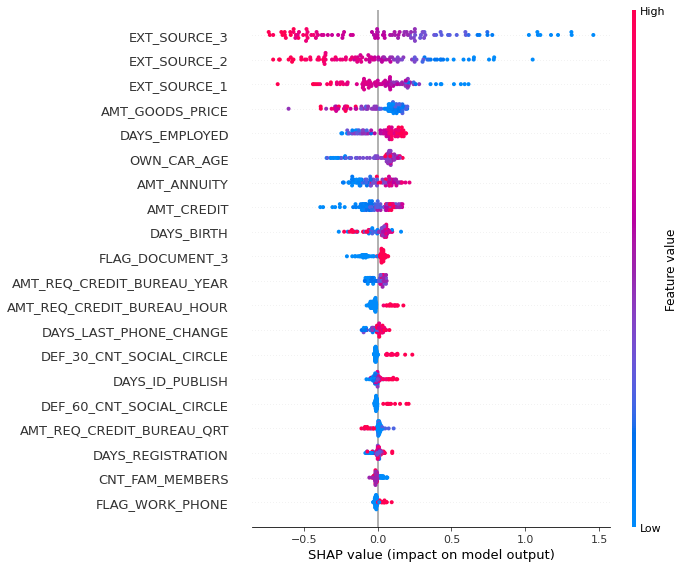

In [59]:
shap.summary_plot(shap_values, X_test.iloc[:100,:])

In [60]:
def dependence(shap_values, X_vald, model_file_path, learner_name):
    fig = plt.figure(figsize=(14, 7))
    plots_cnt = np.min([9, X_vald.shape[1]])
    cols_cnt = 3
    rows_cnt = 3
    if plots_cnt < 4:
        rows_cnt = 1
    elif plots_cnt < 7:
        rows_cnt = 2
    for i in range(plots_cnt):
        ax = fig.add_subplot(rows_cnt, cols_cnt, i + 1)
        shap.dependence_plot(
            f"rank({i})",
            shap_values,
            X_vald,
            show=False,
            title=f"Importance #{i+1}",
            ax=ax,
        )

    fig.tight_layout(pad=2.0)
    fig.show()
    plt.close("all")

In [63]:
dependence(shap_values, X_test.iloc[:100,:], clf, 'RandomForest')


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [64]:
clf_rfc = RandomForestClassifier()
clf_rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [65]:
clf_rfc.score(X_test, y_test)

0.6693521315877812

## ROC CURVE

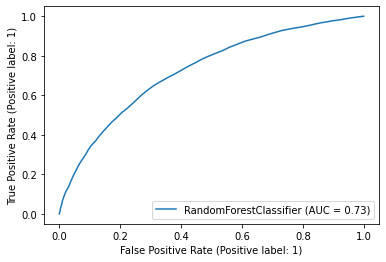

In [66]:
metrics.plot_roc_curve(clf_rfc, X_test, y_test)

## Features Importances

Nous avons enregistré 

In [67]:
df = pd.DataFrame.from_dict(
    {y:x for x, y in zip(clf_rfc.feature_importances_.tolist(), X_test.columns.tolist())}
    , orient='index').reset_index().rename(columns={0:'importance', 'index':'feature'})

In [68]:
df = df.sort_values('importance', ascending=False).to_csv('random_forest_2_importance.csv')


In [69]:
df_0 = pd.read_csv('random_forest_0_importance.csv', index_col='feature')
df_1 = pd.read_csv('random_forest_1_importance.csv', index_col='feature')
df_2 = pd.read_csv('random_forest_2_importance.csv', index_col='feature')

In [70]:
# Model Feature Importance
mfi= pd.DataFrame()
mfi['Random Forest 0'] = df_0[['importance']]
mfi['Random Forest 1'] = df_1[['importance']]
mfi['Random Forest 2'] = df_2[['importance']]

In [71]:
mfi

Random Forest 0  Random Forest 1  Random Forest 2
feature                                                                      
EXT_SOURCE_3                       0.192682         0.169510         0.062628
EXT_SOURCE_2                       0.142525         0.116800         0.046420
EXT_SOURCE_1                       0.134402         0.143110         0.046558
DAYS_EMPLOYED                      0.063301         0.058875         0.027784
OWN_CAR_AGE                        0.042464         0.052555         0.023947
...                                     ...              ...              ...
REG_REGION_NOT_WORK_REGION         0.000000         0.000000         0.001015
FLAG_CONT_MOBILE                   0.000000         0.000000         0.000069
FLAG_DOCUMENT_17                   0.000000         0.000000         0.000000
FLAG_DOCUMENT_4                    0.000000         0.000000         0.000000
FLAG_DOCUMENT_9                    0.000000         0.000000         0.000144

[105 rows x 3 columns]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


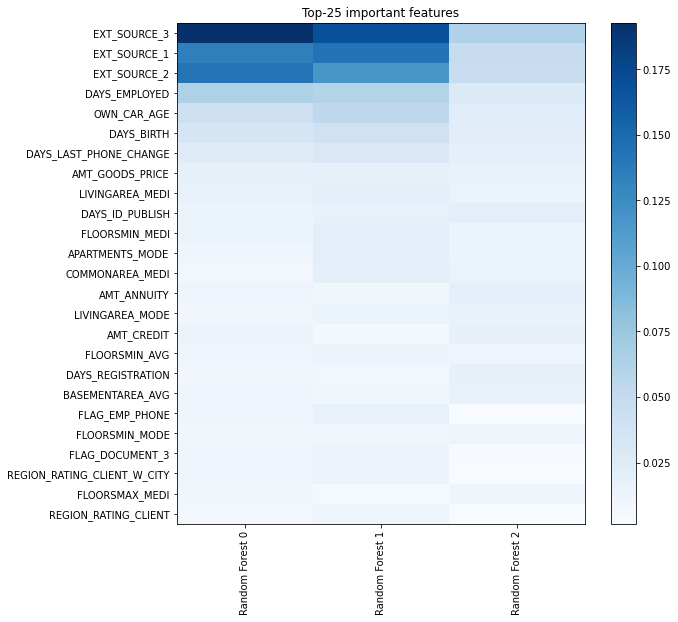

In [72]:
title = "Top-25 important features"
mfi = mfi.iloc[:25]

mfi["m"] = mfi.mean(axis=1)
mfi = mfi.sort_values(by="m", ascending=False)
mfi = mfi.drop("m", axis=1)
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

image = ax.imshow(
    mfi,
    interpolation="nearest",
    cmap=plt.cm.get_cmap("Blues"),
    aspect="auto",
)
plt.colorbar(mappable=image)

x_tick_marks = np.arange(len(mfi.columns))
y_tick_marks = np.arange(len(mfi.index))
ax.set_xticks(x_tick_marks)
ax.set_xticklabels(mfi.columns, rotation=90)
ax.set_yticks(y_tick_marks)
ax.set_yticklabels(mfi.index)
ax.set_title(title)

plt.tight_layout(pad=2.0)
#plot_path = os.path.join(results_path, )
plt.savefig('heatmap.jpg')
plt.show()
plt.close("all")

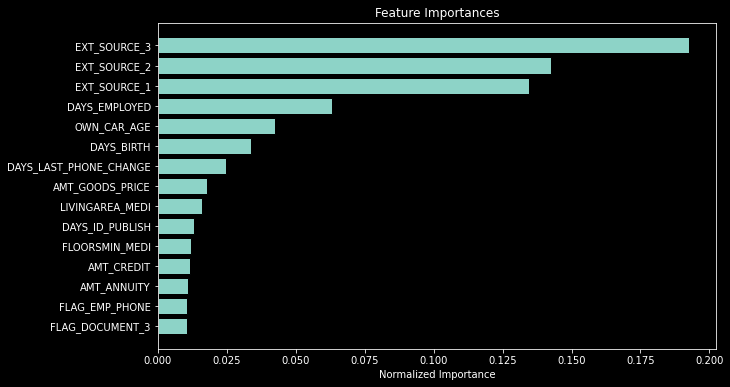

feature  Unnamed: 0  importance  importance_normalized
0       EXT_SOURCE_3          30    0.192682               0.192682
1       EXT_SOURCE_2          29    0.142525               0.142525
2       EXT_SOURCE_1          28    0.134402               0.134402
3      DAYS_EMPLOYED           8    0.063301               0.063301
4        OWN_CAR_AGE          11    0.042464               0.042464
..               ...         ...         ...                    ...
100       FLAG_EMAIL          17    0.000000               0.000000
101  FLAG_DOCUMENT_7          84    0.000000               0.000000
102  FLAG_DOCUMENT_2          79    0.000000               0.000000
103  FLAG_DOCUMENT_5          82    0.000000               0.000000
104  FLAG_DOCUMENT_9          86    0.000000               0.000000

[105 rows x 4 columns]

In [76]:
eda.plot_feature_importances(df_0)

In [77]:
metrics.accuracy_score(y_test, clf_rfc.predict(X_test), normalize=False)

9970

In [78]:
metrics.precision_score(y_test, clf_rfc.predict(X_test))

0.6763636363636364

In [79]:
metrics.recall_score(y_test, clf_rfc.predict(X_test))

0.6493890157110246

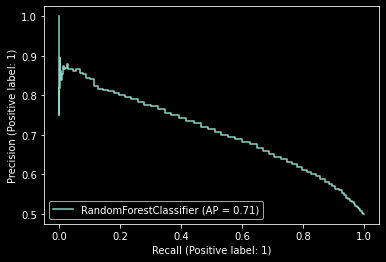

In [80]:
metrics.plot_precision_recall_curve(clf_rfc, X_test, y_test)

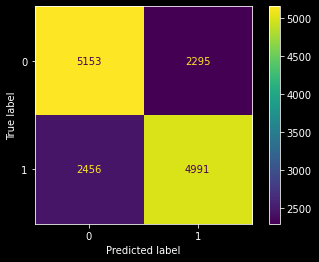

In [81]:
predictions = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions, labels=clf_rfc.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_rfc.classes_)
disp.plot() 

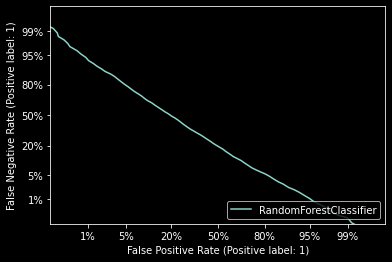

In [82]:
metrics.plot_det_curve(clf_rfc, X_test, y_test)  
plt.show()        

## Features Engineering

In [83]:
def select_kbest(X, y, nb_best):
    #X_plus = X.applymap(lambda x: abs(x)).copy()
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_plus = scaler.transform(X)
    selector = SelectKBest(chi2, k=nb_best)
    selector.fit(X_plus, y)
    X_new = selector.transform(X)
    X_new.shape
    return [list(X.columns)[it] for it, x in enumerate(selector.get_support().tolist()) if x]

In [84]:
def create_poly_features(X, y):
    poly = PolynomialFeatures(2)
    poly.fit(X[select_kbest(X, y, 5)])
    X_new = poly.transform(X[select_kbest(X, y, 5)])
    return X.join(pd.DataFrame(X_new, columns=poly.get_feature_names()).iloc[:,1:]).copy()

In [85]:
def corr_of_target(X, y):
    return X_feats.join(y).corr()['TARGET'].apply(lambda x: abs(x)).sort_values(ascending=False)

In [86]:
def f(x, column, dict_df):
    return dict_df[column.replace('_BINNED', '') + '__' + str(x)]
def score(X, num, columns, num_feat):
    """
    Scoring du client selon les catégories auxquelles il appartient. Le nombre de catégorie
    est passé en paramètre. Il est important de tester plusieurs nombre de catégorie pour 
    trouver la mise en paquet la mieux corrélé à la cible.
    """
    lime_df = pd.DataFrame()
    df_scores = pd.DataFrame()#[[pd.Series([], dtype=str),
    df_insider = pd.DataFrame()                     #pd.Series([], dtype=float)]], columns=['Profil', 'Pourcent'])
    num += 1
    col_data_bin = X[['TARGET']].copy() 
    col_score = pd.DataFrame()
    for col in columns:#X_imp_mean_frozen.select_dtypes('float').drop('TARGET', axis=1).columns.tolist():
        col_data = X[['TARGET', col]].copy() 
        col_max = col_data[col].max()
        col_min = col_data[col].min()
    #print(col_data[col])
        col_data[col + '_BINNED'] = pd.cut(col_data[col], 
                                      bins = np.linspace(col_min, col_max, num = num))
        col_data_bin[col + '_BINNED'] = pd.cut(col_data[col], 
                                      bins = np.linspace(col_min, col_max, num = num))
        col_data_groups  = col_data.groupby(col + '_BINNED').mean()
        col_data_groups[col] = col_data_groups[col].fillna(0)
        for index, row in col_data_groups.iterrows():
            #df_scores = df_scores.append({'Profil': str(col) + str(index),
            #                      'Pourcent': 100 * row['TARGET']}, ignore_index=True)
            df_insider = df_insider.append({'Profil': str(col) + '__' + str(index),
                                  'Pourcent': 100 * row['TARGET']}, ignore_index=True)
            df_insider = df_insider.fillna(0)
        del col_data
    for_dict = {}
    # Écriture de la table de pourcentage en fonction du binned
    # df_insider en dictionnaire pour accéder par key aux valeurs
    for line in df_insider.to_dict(orient='splits')['data']:
        for_dict.update({line[0]: line[1]})
    # Itération dans la table pour créé un score par colonne
    for col in col_data_bin.drop('TARGET', axis=1).columns:
        col_score[col] = col_data_bin[col].apply(lambda x : f(x, col, for_dict))
    # Somme du score de toutes les colonnes pour chaque client
    col_score['SCORE_' + str(num_feat)] = col_score.sum(axis=1)
    norm_data = normalize(col_score['SCORE_'+ str(num_feat)].to_numpy().reshape(1, -1), norm='max')[0]
    return pd.DataFrame(norm_data).rename(columns={0: 'SCORE_'+ str(num_feat)})

## Nous cherchons le score le plus corrélé à la cible

Pour un nombre de colonnes allant de 3 à 50 (parmi les plus corrélées) et un nombre de
paquetage (pour pd.cut()) nous utilisons une fonction linéaire allant de 5 à 50 paquets.
Soit $47\times45$ test

In [87]:
def search_optimum(X,y):
    df_total = pd.DataFrame()
    for nb in range(3, 70):  # nombre de colonnes
        df = []
        df_end = pd.DataFrame(index=X.index)
        with Parallel(n_jobs=8) as parallel:
                result = parallel(
                    delayed(score)(X.join(y), i, select_kbest(X, y, nb), i) 
                    for i in range(2, 30))  # nombre de paquets
                df.append(result)
        #df_end = pd.DataFrame(index=df[0][0].index)
        for i in range(25):
            df_end = df_end.join(df[0][i])
        print(df_end.join(y).corr()['TARGET'].sort_values().index[-2],df_end.join(y).corr()['TARGET'].sort_values()[-2], nb)
        nom = df_end.join(y).corr()['TARGET'].sort_values().index[-2]
        valeur = df_end.join(y).corr()['TARGET'].sort_values()[-2]
        df_total = df_total.append({'Nom': nom + '_' + str(nb), 'Corr': valeur, 'Cols': nb,
                                   'Paquets': nom.split('_')[1]}, ignore_index=True)
    conn = sqlite3.connect('best_score_feature.sqlite')
    df_total.to_sql('best_score_feature.sqlite', conn, if_exists='replace')
    conn.close()
    return df_total

In [88]:
#df_total = search_optimum(X,y) # Dur 30 minutes

In [90]:
conn = sqlite3.connect('best_score_feature.sqlite')
df_total = pd.read_sql('SELECT * FROM `best_score_feature.sqlite`', conn)
df_total.to_csv('best_score_feature.csv')
df_total

index          Nom      Corr  Cols Paquets
0       0   SCORE_25_3  0.136523   3.0      25
1       1   SCORE_26_4  0.193157   4.0      26
2       2   SCORE_26_5  0.169960   5.0      26
3       3   SCORE_26_6  0.190492   6.0      26
4       4   SCORE_26_7  0.189308   7.0      26
..    ...          ...       ...   ...     ...
62     62   SCORE_5_65  0.151913  65.0       5
63     63  SCORE_17_66  0.152363  66.0      17
64     64   SCORE_5_67  0.151487  67.0       5
65     65   SCORE_5_68  0.151501  68.0       5
66     66   SCORE_5_69  0.151327  69.0       5

[67 rows x 5 columns]

## One Hot Encoding and Label Encoding

In [91]:
app_train = pd.read_csv('../data/application_train.csv')

In [92]:
df_object = pd.DataFrame()
col_list = app_train.select_dtypes('object').columns.tolist()
for col in col_list:
    val = app_train[col].unique().shape[0]
    df_object = df_object.append({'Colonne': col, 'Unique': val}, ignore_index=True)
df_object

Colonne  Unique
0           NAME_CONTRACT_TYPE     2.0
1                  CODE_GENDER     3.0
2                 FLAG_OWN_CAR     2.0
3              FLAG_OWN_REALTY     2.0
4              NAME_TYPE_SUITE     8.0
5             NAME_INCOME_TYPE     8.0
6          NAME_EDUCATION_TYPE     5.0
7           NAME_FAMILY_STATUS     6.0
8            NAME_HOUSING_TYPE     6.0
9              OCCUPATION_TYPE    19.0
10  WEEKDAY_APPR_PROCESS_START     7.0
11           ORGANIZATION_TYPE    58.0
12          FONDKAPREMONT_MODE     5.0
13              HOUSETYPE_MODE     4.0
14          WALLSMATERIAL_MODE     8.0
15         EMERGENCYSTATE_MODE     3.0

In [93]:
def label_encoding(X):
    #col_list = []
    df = pd.DataFrame(index=X.index)
    for col in X.select_dtypes('object').columns.tolist():
        if '_lab' in col:
            X.drop(col, axis=1, inplace=True)
        elif X[col].unique().shape[0] == 2:
            le = LabelEncoder()
            le.fit(X[col])
            df = df.join(pd.DataFrame(le.transform(X[col]), 
                                            columns=[col + '_lab']))
    return df #X.join(pd.DataFrame(le.transform(app_train[col]), 
               #                             columns=[col + '_lab']))

In [94]:
def one_hot_encoding(X):
    df = pd.DataFrame(index=X.index)
    col_list = []
    for col in X.select_dtypes('object').columns.tolist():
        if 'OneHotEnc_' in X.columns:
            X.drop(col, axis=1, inplace=True)
        elif (X[col].unique().shape[0] > 2) & (X[col].unique().shape[0] < 25):
            col_list.append(col)

    enc = OneHotEncoder(handle_unknown='ignore')        
    enc.fit(X[col_list])
    abc= enc.transform(X[col_list])
    return pd.DataFrame.sparse.from_spmatrix(abc, \
    columns=['OneHotEnc_' + str(x) for x in range(abc.shape[1])])

In [95]:
X_feats = create_poly_features(X, y)

X_feats['SCORE'] = score(X.join(y), 26, select_kbest(X, y, 4), 4)
X_feats = X_feats.join(label_encoding(app_train))

X_feats = X_feats.join(one_hot_encoding(app_train))

In [96]:
corr_of_target(X_feats, y)

TARGET              1.000000
x3 x4               0.195572
SCORE               0.193157
EXT_SOURCE_3        0.161952
x4                  0.161952
                      ...   
OneHotEnc_49        0.000394
FLAG_CONT_MOBILE    0.000370
FLAG_DOCUMENT_5     0.000316
OneHotEnc_30        0.000312
FLAG_DOCUMENT_20    0.000215
Name: TARGET, Length: 212, dtype: float64

## Préparons un jeu de test et d'entraînement. Espace de Bac à sable pour travailler sur le programme d'automatisation du machine learning

In [97]:
select_kbest(X_feats,y, 15)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


['REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'x0',
 'x1',
 'x3',
 'x0^2',
 'x0 x1',
 'x1^2',
 'x3^2',
 'x3 x4',
 'x4^2',
 'SCORE',
 'OneHotEnc_1',
 'OneHotEnc_20']

In [98]:

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(X_feats, y)
for train_index, test_index in sss.split(X_feats, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 91529 173989 140885 ... 272555 164417 291294] TEST: [220956  51072  86405 ... 218515 134766  36309]


In [99]:
X_feats.to_csv('X_feats.csv', index_label='index')
y.to_csv('y.csv', index_label='index')

In [100]:
select_kbest(X_feats, y, 5)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


['x3^2', 'x3 x4', 'x4^2', 'SCORE', 'OneHotEnc_20']

In [101]:
a = pd.DataFrame.from_dict({'k': None}, orient='index').T['k'][0]

In [102]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5,
                           random_state=0,
                           n_jobs=-1,
                           verbose=2,
                           max_iter=50,
                           tol=1e-5,
                           penalty='l2',
                           scoring='f1_micro',
                           class_weight={1:1,0:0.1}).fit(X_train, y_train)
#y_test = clf.predict(X)

#clf.predict_proba(X).shape

clf.score(y, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          106     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06089D+04    |proj g|=  8.94011D+08

At iterate    1    f=  2.04889D+04    |proj g|=  1.10112D+08

At iterate    2    f=  2.04862D+04    |proj g|=  8.36478D+07

At iterate    3    f=  2.04743D+04    |proj g|=  5.95590D+07

At iterate    4    f=  2.04586D+04    |proj g|=  7.04102D+07

At iterate    5    f=  2.04075D+04    |proj g|=  8.06011D+07

At iterate    6    f=  2.03558D+04    |proj g|=  8.16378D+07

At iterate    7    f=  2.03169D+04    |proj g|=  9.40090D+07

At iterate    8    f=  2.02954D+04    |proj g|=  3.33932D+07

At iterate    9    f=  2.02864D+04    |proj g|=  3.08692D+07

At iterate   10    f=  2.02855D+04    |proj g|=  2.92360D+07

At iterate   11    f=  2.02841D+04    |proj g|=  5.51588D+07

At iterate   12    f=  2.02816D+04    |proj g|=  5.29762D+07

At iterate   13    f=  2.0

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          106     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06089D+04    |proj g|=  8.97556D+08

At iterate    1    f=  2.04860D+04    |proj g|=  6.43556D+07

At iterate    2    f=  2.04804D+04    |proj g|=  6.82124D+07

At iterate    3    f=  2.04416D+04    |proj g|=  1.66392D+08

At iterate    4    f=  2.04182D+04    |proj g|=  1.62994D+08

At iterate    5    f=  2.03061D+04    |proj g|=  2.78682D+08

At iterate    6    f=  2.02890D+04    |proj g|=  5.74122D+07

At iterate    7    f=  2.02867D+04    |proj g|=  2.28680D+07

At iterate    8    f=  2.02861D+04    |proj g|=  3.13267D+07

At iterate    9    f=  2.02844D+04    |proj g|=  3.25745D+07

At iterate   10    f=  2.02805D+04    |proj g|=  2.37873D+07

At iterate   11    f=  2.02772D+04    |proj g|=  9.58408D+06

At iterate   12    f=  2.02722D+04    |proj g|=  2.91021D+07

At iterate   13    f=  2.0

At iterate    3    f=  1.99192D+04    |proj g|=  2.76714D+07

At iterate    4    f=  1.99191D+04    |proj g|=  8.85275D+06

At iterate    5    f=  1.99190D+04    |proj g|=  6.13132D+06

At iterate    6    f=  1.99190D+04    |proj g|=  1.41670D+06

At iterate    7    f=  1.99190D+04    |proj g|=  2.48916D+06

At iterate    8    f=  1.99189D+04    |proj g|=  5.06509D+06

At iterate    9    f=  1.99189D+04    |proj g|=  8.06581D+06

At iterate   10    f=  1.99188D+04    |proj g|=  1.02533D+07

At iterate   11    f=  1.99187D+04    |proj g|=  8.17452D+06

At iterate   12    f=  1.99186D+04    |proj g|=  5.12117D+06

At iterate   13    f=  1.99186D+04    |proj g|=  1.57944D+07

At iterate   14    f=  1.99186D+04    |proj g|=  5.93644D+06

At iterate   15    f=  1.99186D+04    |proj g|=  3.56926D+06

At iterate   16    f=  1.99185D+04    |proj g|=  5.63159D+06

At iterate   17    f=  1.99183D+04    |proj g|=  9.82165D+06

At iterate   18    f=  1.99180D+04    |proj g|=  1.64640D+07

At itera

At iterate    3    f=  1.99246D+04    |proj g|=  4.32757D+07

At iterate    4    f=  1.99208D+04    |proj g|=  1.23574D+07

At iterate    5    f=  1.99206D+04    |proj g|=  8.57539D+06

At iterate    6    f=  1.99205D+04    |proj g|=  6.60604D+06

At iterate    7    f=  1.99203D+04    |proj g|=  5.17761D+06

At iterate    8    f=  1.99199D+04    |proj g|=  1.42901D+07

At iterate    9    f=  1.99192D+04    |proj g|=  3.47729D+07

At iterate   10    f=  1.99183D+04    |proj g|=  2.36734D+07

At iterate   11    f=  1.99179D+04    |proj g|=  5.00297D+06

At iterate   12    f=  1.99179D+04    |proj g|=  3.54095D+06

At iterate   13    f=  1.99178D+04    |proj g|=  6.10012D+06

At iterate   14    f=  1.99177D+04    |proj g|=  5.28076D+06

At iterate   15    f=  1.99175D+04    |proj g|=  1.97350D+07

At iterate   16    f=  1.99174D+04    |proj g|=  1.10756D+07

At iterate   17    f=  1.99172D+04    |proj g|=  8.00724D+06

At iterate   18    f=  1.99167D+04    |proj g|=  2.34133D+07

At itera

At iterate    9    f=  1.98808D+04    |proj g|=  3.29022D+06

At iterate   10    f=  1.98807D+04    |proj g|=  4.73911D+06

At iterate   11    f=  1.98806D+04    |proj g|=  5.35784D+06

At iterate   12    f=  1.98805D+04    |proj g|=  1.34193D+07

At iterate   13    f=  1.98801D+04    |proj g|=  1.19892D+07

At iterate   14    f=  1.98799D+04    |proj g|=  4.22120D+07

At iterate   15    f=  1.98793D+04    |proj g|=  2.17202D+07

At iterate   16    f=  1.98785D+04    |proj g|=  9.22133D+06

At iterate   17    f=  1.98778D+04    |proj g|=  1.86154D+07

At iterate   18    f=  1.98771D+04    |proj g|=  1.77460D+07

At iterate   19    f=  1.98771D+04    |proj g|=  2.00279D+07

At iterate   20    f=  1.98768D+04    |proj g|=  8.18550D+06

At iterate   21    f=  1.98767D+04    |proj g|=  7.82525D+06

At iterate   22    f=  1.98767D+04    |proj g|=  6.71850D+05

At iterate   23    f=  1.98767D+04    |proj g|=  6.53175D+05

At iterate   24    f=  1.98767D+04    |proj g|=  6.60804D+05

At itera

At iterate    3    f=  1.99584D+04    |proj g|=  4.51593D+06

At iterate    4    f=  1.99584D+04    |proj g|=  1.00301D+07

At iterate    5    f=  1.99583D+04    |proj g|=  2.16214D+07

At iterate    6    f=  1.99579D+04    |proj g|=  3.66830D+07

At iterate    7    f=  1.99572D+04    |proj g|=  4.23445D+07

At iterate    8    f=  1.99565D+04    |proj g|=  4.36127D+07

At iterate    9    f=  1.99558D+04    |proj g|=  7.55974D+06

At iterate   10    f=  1.99553D+04    |proj g|=  5.44555D+06

At iterate   11    f=  1.99542D+04    |proj g|=  1.71616D+07

At iterate   12    f=  1.99532D+04    |proj g|=  2.54065D+07

At iterate   13    f=  1.99528D+04    |proj g|=  2.54309D+07

At iterate   14    f=  1.99523D+04    |proj g|=  2.45409D+07

At iterate   15    f=  1.99521D+04    |proj g|=  2.52918D+07

At iterate   16    f=  1.99517D+04    |proj g|=  2.44171D+07

At iterate   17    f=  1.99506D+04    |proj g|=  1.74650D+07

At iterate   18    f=  1.99504D+04    |proj g|=  1.23675D+07

At itera

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.3s remaining:   44.0s


At iterate   15    f=  1.99012D+04    |proj g|=  2.06226D+06

At iterate   16    f=  1.99012D+04    |proj g|=  4.78904D+05

At iterate   17    f=  1.99012D+04    |proj g|=  7.01456D+05

At iterate   18    f=  1.99012D+04    |proj g|=  1.00637D+06

At iterate   19    f=  1.99012D+04    |proj g|=  1.22950D+06

At iterate   20    f=  1.99012D+04    |proj g|=  1.81265D+06

At iterate   21    f=  1.99012D+04    |proj g|=  1.52135D+06

At iterate   22    f=  1.99011D+04    |proj g|=  3.72181D+06

At iterate   23    f=  1.99009D+04    |proj g|=  8.24854D+06

At iterate   24    f=  1.99007D+04    |proj g|=  1.12200D+07

At iterate   25    f=  1.99007D+04    |proj g|=  1.50190D+07

At iterate   26    f=  1.99006D+04    |proj g|=  1.07712D+07

At iterate   27    f=  1.99005D+04    |proj g|=  4.55587D+06

At iterate   28    f=  1.99005D+04    |proj g|=  8.97617D+05

At iterate   29    f=  1.99005D+04    |proj g|=  7.51501D+05

At iterate   30    f=  1.99005D+04    |proj g|=  9.02001D+05

At itera

At iterate    9    f=  1.99040D+04    |proj g|=  2.10316D+07

At iterate   10    f=  1.99036D+04    |proj g|=  1.82270D+07

At iterate   11    f=  1.99035D+04    |proj g|=  9.14731D+06

At iterate   12    f=  1.99035D+04    |proj g|=  7.76860D+05

At iterate   13    f=  1.99035D+04    |proj g|=  5.87304D+05

At iterate   14    f=  1.99035D+04    |proj g|=  5.83265D+05

At iterate   15    f=  1.99035D+04    |proj g|=  1.54642D+06

At iterate   16    f=  1.99034D+04    |proj g|=  2.14177D+06

At iterate   17    f=  1.99034D+04    |proj g|=  1.30209D+07

At iterate   18    f=  1.99034D+04    |proj g|=  8.87332D+06

At iterate   19    f=  1.99033D+04    |proj g|=  5.89726D+06

At iterate   20    f=  1.99031D+04    |proj g|=  6.65618D+06

At iterate   21    f=  1.99030D+04    |proj g|=  1.09675D+07

At iterate   22    f=  1.99030D+04    |proj g|=  6.94356D+06

At iterate   23    f=  1.99030D+04    |proj g|=  2.54788D+06

At iterate   24    f=  1.99030D+04    |proj g|=  2.97339D+05

At itera

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.5s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


ValueError: Expected 2D array, got 1D array instead:
array=[1 0 0 ... 0 1 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn.metrics import plot_roc_curve

svc_disp = plot_roc_curve(clf, X_test, y_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
liste_str=['nu',
           'kernel',
           'degree',
           'gamma', 
           'coef0',
           'shrinking',
           'probability',
           'tol',
           'cache_size',
           'class_weight',
           'verbose',
           'max_iter',
           'decision_function_shape',
           'break_ties',
           'random_state']

In [ ]:
for l in liste_str:
    #print('self.' + l + '= params[\'' + l + '\'] if not pd.isna(params[\'' + l
    #      + '\']) else df_init[\'' + l + '\'].values.ravel()')
    print('\''+ l + '\': xxxxxx ,')

/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docum

At iterate   15    f=  1.98876D+04    |proj g|=  5.32367D+06

At iterate   16    f=  1.98876D+04    |proj g|=  1.53173D+06

At iterate   17    f=  1.98876D+04    |proj g|=  8.32788D+05

At iterate   18    f=  1.98876D+04    |proj g|=  4.76873D+05

At iterate   19    f=  1.98876D+04    |proj g|=  6.53622D+05

At iterate   20    f=  1.98876D+04    |proj g|=  2.22323D+06

At iterate   21    f=  1.98876D+04    |proj g|=  5.44072D+06

At iterate   22    f=  1.98875D+04    |proj g|=  7.66621D+06

At iterate   23    f=  1.98875D+04    |proj g|=  5.73527D+06

At iterate   24    f=  1.98875D+04    |proj g|=  7.18201D+06

At iterate   25    f=  1.98875D+04    |proj g|=  4.00529D+06

At iterate   26    f=  1.98874D+04    |proj g|=  4.93591D+06

At iterate   27    f=  1.98873D+04    |proj g|=  9.56331D+06

At iterate   28    f=  1.98872D+04    |proj g|=  8.17712D+06

At iterate   29    f=  1.98870D+04    |proj g|=  7.61650D+06

At iterate   30    f=  1.98870D+04    |proj g|=  2.91114D+07

At itera

/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docum

Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  106     50     61      1     0     0   5.733D+04   1.987D+04
  F =   19870.980830689547     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          106     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98710D+04    |proj g|=  5.73322D+04

At iterate    1    f=  1.98710D+04    |proj g|=  6.05090D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final functio

/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docum

F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  106      1      5      1     0     0   2.226D+05   1.990D+04
  F =   19898.955479897591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docum

At iterate   21    f=  1.98692D+04    |proj g|=  4.90890D+06

At iterate   22    f=  1.98691D+04    |proj g|=  5.82595D+06

At iterate   23    f=  1.98691D+04    |proj g|=  8.58214D+06

At iterate   24    f=  1.98690D+04    |proj g|=  4.99926D+06

At iterate   25    f=  1.98690D+04    |proj g|=  1.27218D+06

At iterate   26    f=  1.98690D+04    |proj g|=  2.58949D+05

At iterate   27    f=  1.98690D+04    |proj g|=  3.31832D+05

At iterate   28    f=  1.98690D+04    |proj g|=  1.02749D+05

At iterate   29    f=  1.98690D+04    |proj g|=  2.97577D+05

At iterate   30    f=  1.98690D+04    |proj g|=  6.39802D+05

At iterate   31    f=  1.98690D+04    |proj g|=  8.45520D+05

At iterate   32    f=  1.98690D+04    |proj g|=  1.16549D+06

At iterate   33    f=  1.98689D+04    |proj g|=  2.15707D+06

At iterate   34    f=  1.98689D+04    |proj g|=  8.94193D+05

At iterate   35    f=  1.98689D+04    |proj g|=  4.96227D+06

At iterate   36    f=  1.98689D+04    |proj g|=  2.10949D+06

At itera

/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docum

  F =   19893.229245001261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
